In [1]:
import sys
sys.path.append("../")

from rbm import fasta_read
from crbm import get_beta_and_W, all_weights, CRBM
import rbm_utils
import analysis_methods as am

from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import math
import subprocess as sp
import matplotlib.image as mpimg

In [2]:
# Directory of Stored CRBMs
mdir = "/mnt/D1/globus/cov_trained_crbms/"
rounds = [f"r{i}" for i in range(1, 13)]

#### Generate Weights

In [3]:
# generate weights in respective
for rid, round in enumerate(rounds[8:]):
    # if rid > 0:
    #     break
    checkp, version_dir = am.get_checkpoint_path(round, rbmdir=mdir)
    tmp = CRBM.load_from_checkpoint(checkp)
    all_weights(tmp, base_name=version_dir +round)

../rbm_utils.py:439: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (95040000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [3]:
def assign(x):
    if x < 10:
        return "L" # low
    elif x < 1000:
        return "M" # medium
    else:
        return "H" # High

# Stores all data in a dictionary ("data")
all_data = am.fetch_data(rounds[1:], dir="../../cov", assignment_function=assign, threads=12)

Process Time 6.453129053115845
Process Time 0.4675276279449463
Process Time 0.3645596504211426
Process Time 1.4566552639007568
Process Time 1.0920021533966064
Process Time 1.7132041454315186
Process Time 0.6163880825042725
Process Time 0.16119384765625
Process Time 0.3885490894317627
Process Time 0.18430757522583008
Process Time 0.44092440605163574


In [5]:
# Generate Sequence Logo for Each round
paths_u, paths_w = [], []
for r in rounds:
    paths_u.append(am.seq_logo(all_data[all_data["round"] == r], f"{r}_seqlogo", weight=False, outdir="./generated/"))
    paths_w.append(am.seq_logo(all_data[all_data["round"] == r], f"{r}_w_seqlogo", weight=True, outdir="./generated/"))

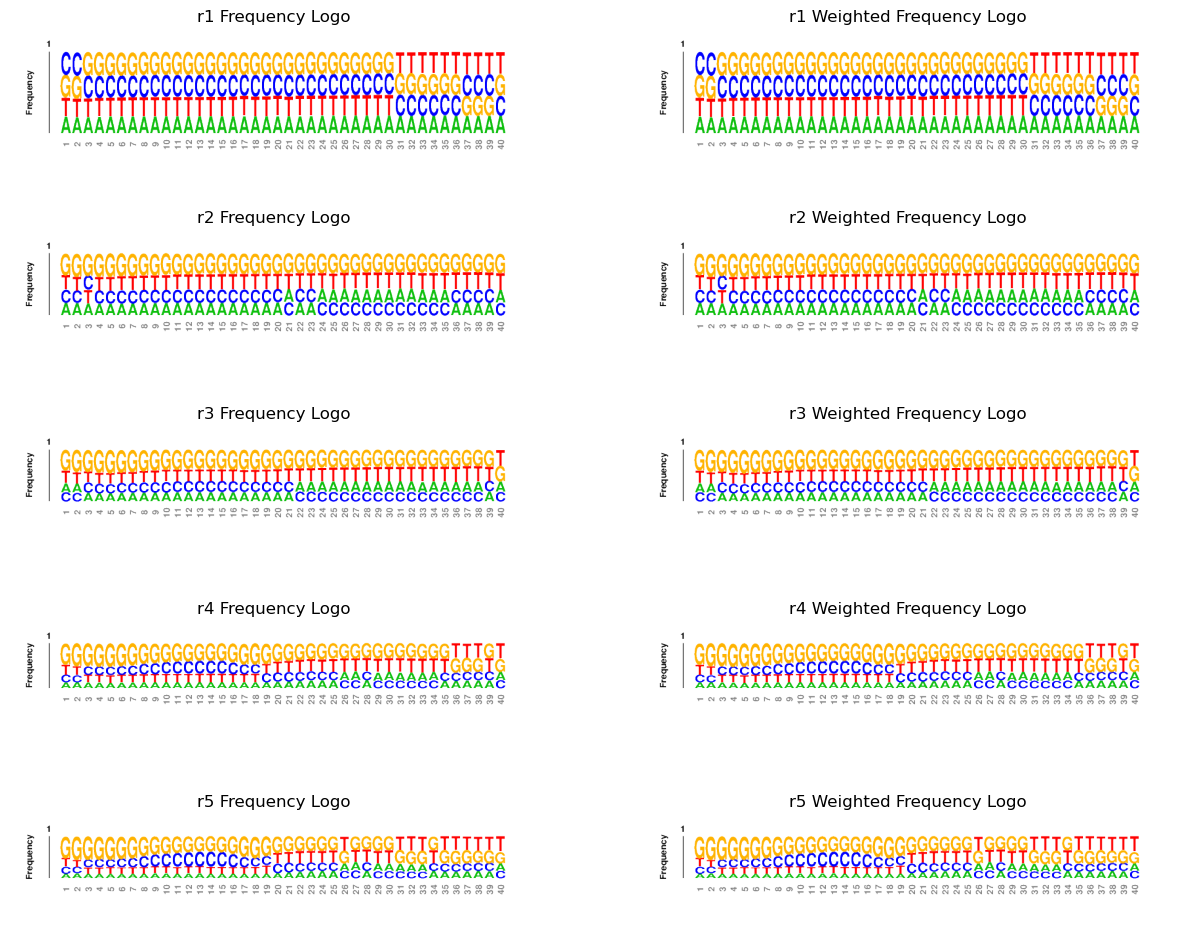

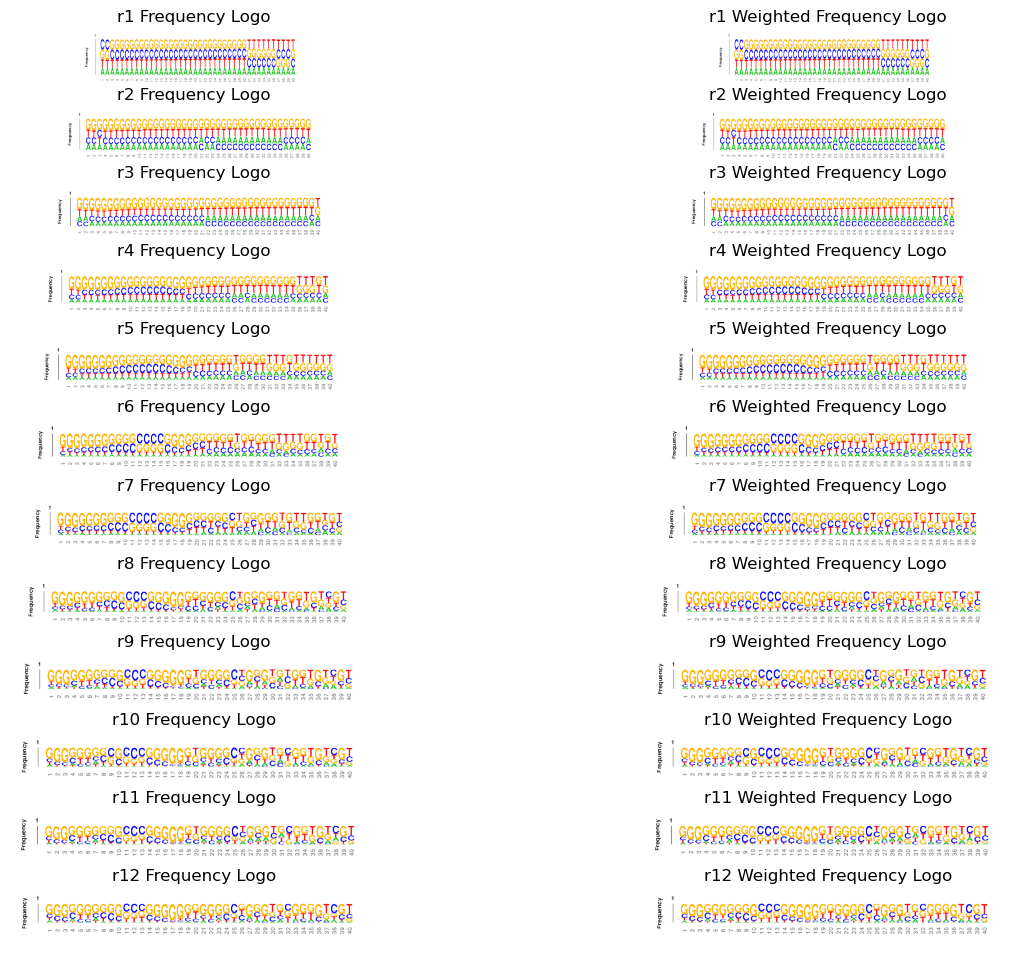

In [7]:
# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds):
    img1 = mpimg.imread(f"{paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()

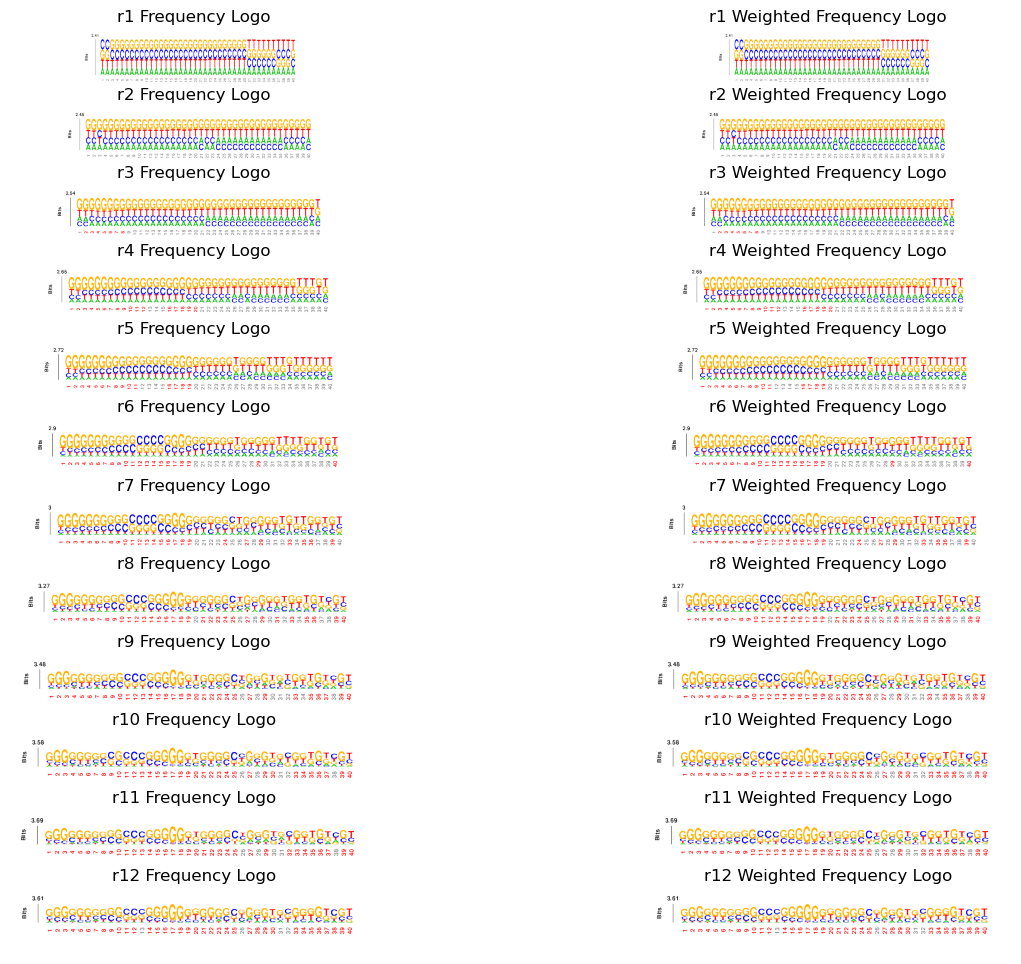

In [8]:
# Seq Logo showing Information of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds):
    img1 = mpimg.imread(f"{paths_u[rid]}.info.png")
    img2 = mpimg.imread(f"{paths_u[rid]}.info.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()

In [ ]:
def count_dist(data_w_counts, title):
    fig, axs = plt.subplots(2, 1)
    sns.histplot(data=data_w_counts, ax=axs[0], x="round", hue="assignment", multiple="fill", palette="rocket", stat="percent")
    sns.histplot(data=data_w_counts, ax=axs[1], x="round", hue="assignment", multiple="stack", palette="rocket", stat="count")
    # sns.barplot(data=data_w_counts, ax=axs[0], x="round", y="copynum")
    plt.suptitle(title)
    plt.show()

count_dist(all_data, "Unique Sequence Count Distribution")

In [4]:
# Low count == 1, Med count < 10, High count >= 10
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("r12", rbmdir=mdir)
r12_crbm = CRBM.load_from_checkpoint(checkp)

In [6]:
# this takes awhile, might be something I optimize further in the future
am.generate_likelihoods(rounds[1::2], r12_crbm, all_data, "crbm_r12_v0")

In [5]:
r12_likelihoods = am.get_likelihoods("./generated/crbm_r12_v0.json")

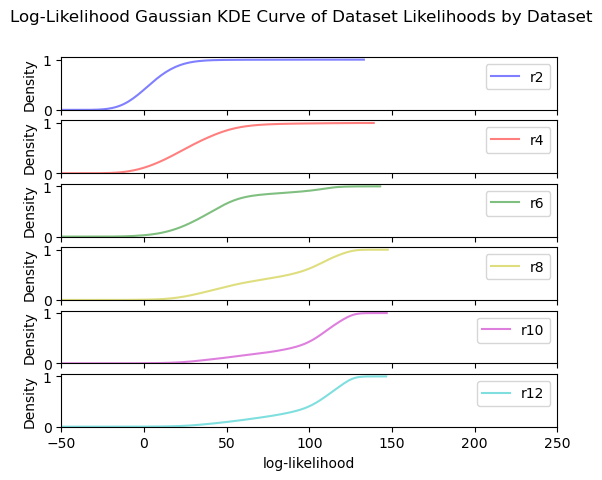

In [10]:
# Plot Likelihoods of Each batch of Data
am.plot_likelihoods(r12_likelihoods["likelihoods"], rounds[1::2], rounds[1::2], xlim=(-50, 250), cdf=True)

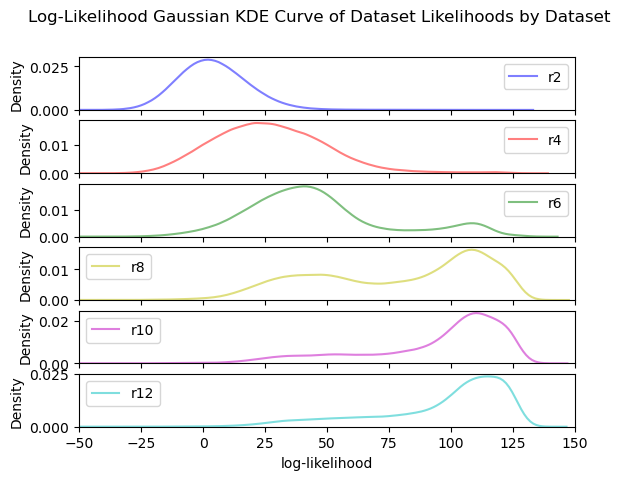

In [11]:
am.plot_likelihoods(r12_likelihoods["likelihoods"], rounds[1::2], rounds[1::2], xlim=(-50, 150), cdf=False)

In [12]:
def shaded_kde_curve(ax, path, xmin, xmax, color):
    vertices = [ (x, y) for x, y in path.vertices if xmin < x < xmax]
    vertices.insert(0, (xmin, 0.))
    vertices.append((xmax, 0.))
    xfill, yfill = zip(*vertices)
    ax.fill(xfill, yfill, color)

def color_subplot(ax, color):
    for spine in ax.spines.values():
        spine.set_edgecolor(color)

def seqlogo_subplot(ax, path, type="info"):
    img = mpimg.imread(f"{path}.{type}.png")
    ax.imshow(img, interpolation="nearest")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# bounds listed in ascending order
def multi_peak_seq_log_fig(data, likelihoods, round, bounds, weight=False, title=None, xlim=None):
    data_subsets, seqlogo_paths = [], []
    for iid,  i in enumerate(bounds):
        sub = am.data_subset(data, likelihoods, round, i[0], i[1])
        seqlogo_paths.append(am.seq_logo(sub, f"peak{iid+1}_likeli_{round}", weight=weight, outdir="./generated/"))
        data_subsets.append(sub)

    peak_num = len(bounds)
    gs_kw = dict(width_ratios=[1 for x in range(peak_num)], height_ratios=[1, 1])
    fig, axd = plt.subplot_mosaic([['top' for x in range(peak_num)], [f'lower{x}' for x in range(peak_num)]],
                                  gridspec_kw=gs_kw, figsize=(15, 5), constrained_layout=False)

    axd["top"].set_xlim(*xlim)
    sns.kdeplot(likelihoods[round], ax=axd["top"])

    path = axd["top"].get_children()[0].get_path()

    for iid, i in enumerate(bounds):
         shaded_kde_curve(axd["top"], path, i[0], i[1], am.supported_colors[iid])

    axd["top"].set_xlabel("log-likelihood")
    for iid, i in enumerate(bounds):
        color_subplot(axd[f"lower{iid}"], am.supported_colors[iid])
        seqlogo_subplot(axd[f"lower{iid}"], seqlogo_paths[iid])

    if title is None:
        fig.suptitle(title)
    else:
        fig.suptitle(f"Composition of peaks across RBM Likelihood of Round{round}")

    plt.show()



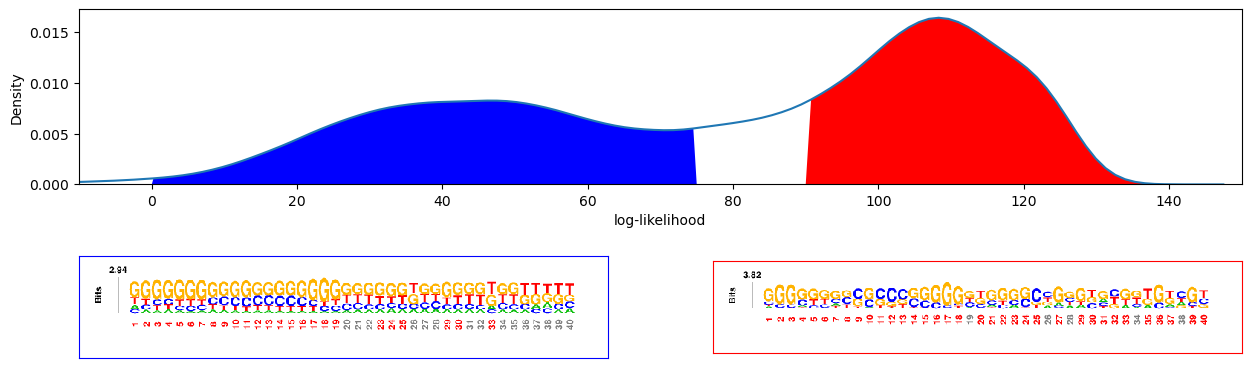

In [14]:
multi_peak_seq_log_fig(all_data, r12_likelihoods["likelihoods"], "r8", [[0, 75], [90, 140]], weight=False, xlim=(-10, 150))

In [15]:
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("r2", rbmdir=mdir)
r2_rbm = CRBM.load_from_checkpoint(checkp)

ValueError: max() arg is an empty sequence

In [ ]:
# this takes awhile, might be something I optimize further in the future
# am.generate_likelihoods(rounds[1::2], r2_rbm, all_data, "r2_v0_even_rounds")

In [6]:
r2_likelihoods = am.get_likelihoods("./generated/r2_v0_even_rounds.json")

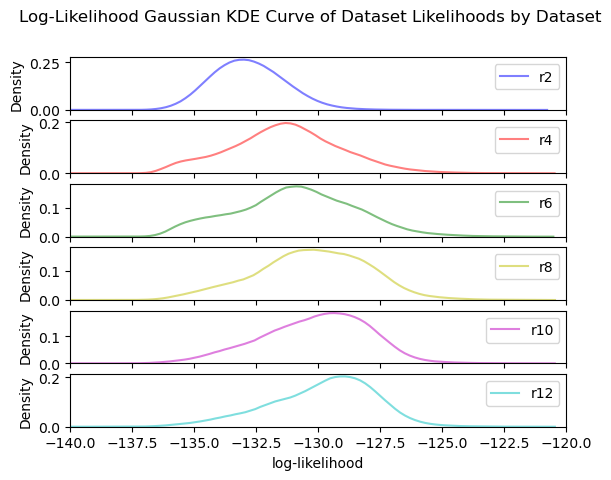

In [13]:
# assign likelihoods in new pd dataframe
am.plot_likelihoods(r2_likelihoods["likelihoods"], rounds[1::2], rounds[1::2], xlim=(-140, -120))

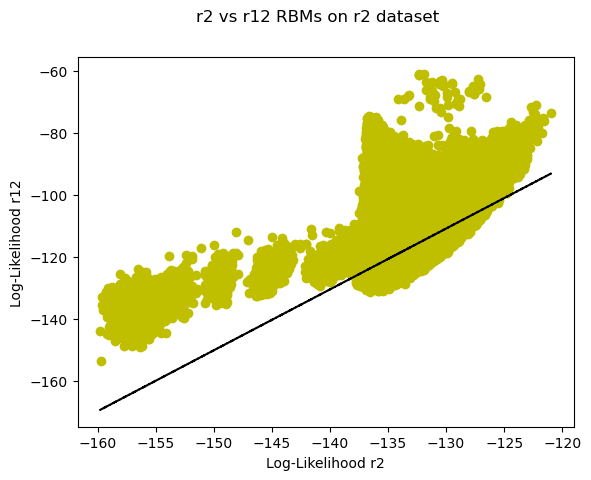

In [16]:
am.compare_likelihood_correlation(r2_likelihoods["likelihoods"]["r2"], r12_likelihoods["likelihoods"]["r2"], "r2 vs r12 RBMs on r2 dataset", ["r2", "r12"])

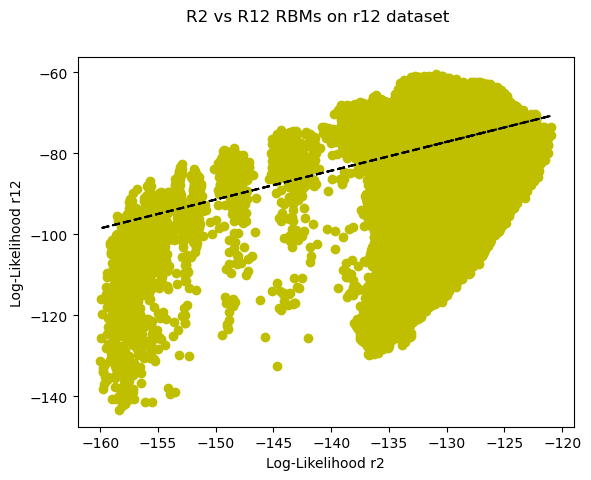

In [18]:
am.compare_likelihood_correlation(r2_likelihoods["likelihoods"]["r12"], r12_likelihoods["likelihoods"]["r12"], "R2 vs R12 RBMs on r12 dataset", ["r2", "r12"])

In [21]:
exp_seqs = {
    "SP5": 'ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT',
    "SP6": "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT",
    "SP7": "CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT",
    "SP6C": 'CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT',
    "SP634":  "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGG------",
    "SP634G": "CCCATGGTAGGTATTGGTTGGTAGGGATAGTGGG------",
    "SP634C": "CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGG------",
    "SP634A": "CCCATGGTAGGTATTGCATGGTAGGGATAGTGGG------",
    "SP630":  "---CATGGTAGGTATTGCATGGTAGGGATAGTG-------",
    "SP619":  "------------TATTGCATGGTAGGGATAG---------",
}

keys = exp_seqs.keys()
values = exp_seqs.values()
new_exp_seqs = {}
set_nuc = "A"
for i in keys:
    seq = exp_seqs[i]
    while "-" in seq:
        new_char = np.random.choice(["A", "C", "G", "T"])
        # new_char = set_nuc
        ind = seq.find("-")
        seq = seq[:ind] + new_char + seq[ind+1:]
    new_exp_seqs[i] = seq

rand_exp_seqs = new_exp_seqs
rand_exp_set = {'id':list(new_exp_seqs.keys()), 'sequence':list(new_exp_seqs.values())}
rand_exp_pd = pd.DataFrame(rand_exp_set)

exp_A_seqs = {
    "SP5":       'ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT',
    "SP6":       "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT",
    "SP7":       "CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT",
    "SP6C":      'CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT',
    "SP634":     "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAAAAA",
    "SP634G":    "ACCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAAAAA",
    "SP634C":    "CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAAAAA",
    "SP634A":    "CCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAAAAA",
    "SP630":     "AACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAAAAA",
    "SP619":     "AAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAAAAA",
    "r12_align": "AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTTGATT"
}
exp_A_set = {'id':list(exp_A_seqs.keys()), 'sequence':list(exp_A_seqs.values())}
exp_A_pd = pd.DataFrame(exp_A_set)


exp_set = {'id':list(exp_seqs.keys()), 'sequence':list(exp_seqs.values())}
exp_pd = pd.DataFrame(exp_set)

In [22]:
# exp_2_seqs, exp_2_likelis = r2_rbm.predict(exp_pd)
# exp_2_A_seqs, exp_2_A_likelis = r2_rbm.predict(exp_A_pd)
exp_12_seqs, exp_12_likelis = r12_crbm.predict(exp_pd)
exp_12_rand_seqs, exp_12_rand_likelis = r12_crbm.predict(rand_exp_pd)

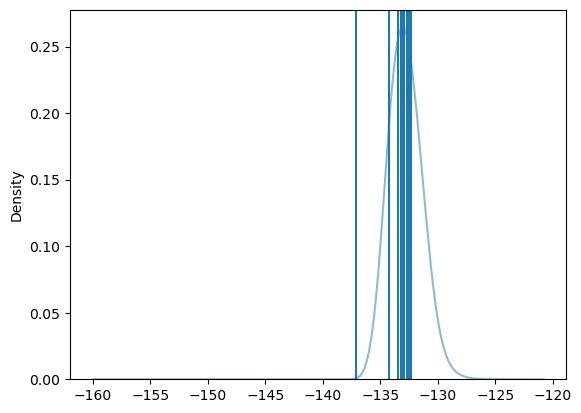

In [17]:
fig, axs = plt.subplots(1, 1)
y = sns.kdeplot(r2_likelihoods["likelihoods"]["r2"], shade=False, alpha=0.5, ax=axs)
for likeli in exp_2_A_likelis:
    plt.axvline(likeli)
plt.show()

In [18]:
for i in range(len(exp_seqs)):
    print(exp_2_A_seqs[i], exp_2_A_likelis[i])

TCAACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT -132.68197807155985
CAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTT -132.51246189410242
CAAAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCG -132.31719745223856
CAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTT -132.93433717970836
AAACCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAA -133.00513372045458
AAACCCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAA -132.61341545160053
AAACCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAA -133.42270537788107
AAACCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAA -133.18874658196373
AAAAACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAA -134.20747154167958
AAAAAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAA -137.0695806022038


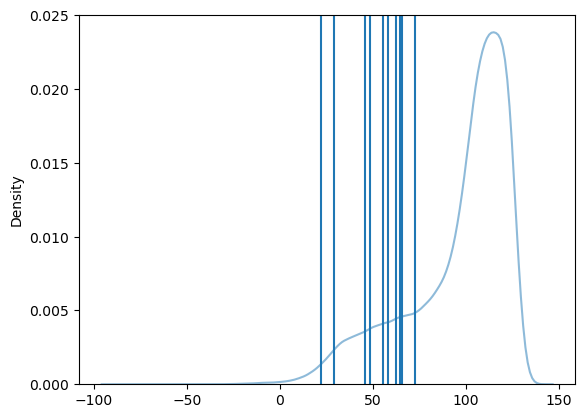

In [23]:
fig, axs = plt.subplots(1, 1)
y = sns.kdeplot(r12_likelihoods["likelihoods"]["r12"], shade=False, alpha=0.5, ax=axs)
for likeli in exp_12_rand_likelis:
    plt.axvline(likeli)
plt.show()

In [26]:
labels = list(exp_seqs.keys())
for i in range(len(exp_seqs)):
    print(labels[i], exp_12_rand_seqs[i], exp_12_rand_likelis[i])

SP5 ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT 64.73579162895203
SP6 CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT 65.80233227010103
SP7 CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT 72.53920118164251
SP6C CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT 57.84669211258779
SP634 CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTCGTC 55.16241277357608
SP634G CCCATGGTAGGTATTGGTTGGTAGGGATAGTGGGGCCGCA 62.09695458333567
SP634C CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCGGCTG 48.45978498541854
SP634A CCCATGGTAGGTATTGCATGGTAGGGATAGTGGGCGTCTA 45.62802930557973
SP630 GTTCATGGTAGGTATTGCATGGTAGGGATAGTGGCTACTA 22.086382808362487
SP619 ACAGCGGGTTGTTATTGCATGGTAGGGATAGTGTTCTCCG 29.17192714906423


In [20]:
r12_likelihoods.keys()

dict_keys(['likelihoods', 'sequences'])

In [28]:
lik = r12_likelihoods["likelihoods"]["r12"]
seq = r12_likelihoods["sequences"]["r12"]

for lid, l in enumerate(lik):
    if l > 130:
        print(seq[lid])

AGGCTTATGGCCTGGGGGGGGGGCCCGGGTGGGGGGTCGT
TGGATTATCGCCGGGGGGGGGGGCCCGGGTGGGGGGTCGT
CGGCTAATCGTCCGGGGGGGGGGCCCGGGTGCGGGGTCGT
CGGCTTAGCGTCGGGGGGGGGGGCCGGGGGGGGGGGTCGT
AGGCTTAGCGTCCGGGGGGGGGGCCCGGGTGGGGGGTCGT
GCCCGGCGGGCTGGGGGGGGGGGGTGGGGTGGGGGGTCCT
TGGCTTATGGCCGGGGGGGGGGGCCCGGGTGCGGGGTCGT
GGGGGCGCCCCCCCCCCCCGGGGGTCGTTTCTACAGTGGG
TGGCTTATCGTCTGGGGGGGGGGCCGGGGTGGGGGGTCGT
CCCCCCCGGCCTGGGGGGGGGGGTTGGGGGGGGGGGTCCT
CCCCCCCCGCCTCGGGGGGGGGGGTGGGGTGGGGGGTCCT
GGGCTTAGCGTCGGGGGGGTGGGCCGGGGTGCGGGGTCGT
AGGTTTATGGTCGGGGGGGGGGGCCGGGGTGCGGGGTCGT
CCCCCGCGGGTTGGGGGGGGGGGGTGGGGGGCGGGGTCCT
GGGGGGGCCGGCTCGGGAATGGGGTCGTTTCTACAGTGGG
CCCCCGCCGGCTTGGGGGGGTGGTTTGGGTGGGGGGTCCT
CCCCCGCCGGCTGGGGGGGGGGGGGGGGGGGGGGGGTCCT
TGGTTTAGGGCCGGGGGGGGGGGCCGGGGTGGGGGGTCGT
CCCCGGCGGGCTGGGGGGGGTGGGTTGGGTGGGGGGTCCT
CGGATAATCGTCCGGGGGGGGGGCCCGGGTGGGGGGTCGT
CCCCCGCGGGTTGGGGGGGGGGGTTTGGGTTCGGGGTCCT
TGGGGGGGTGGGTAGGGAATGGGGTCGTTTCTACAGTGGG
GGGCTTACCGCCTGGGGGGGGGGCCGGGGTGCGGGGTCGT
CCCCCGCCGGCTGGGGGGGGGGGTCTGGGTGGGGGGTCCT
AGGCTTATCGTCTGGG

##Clustering with the r12 RBM

In [10]:
import torch
import rbm_utils

def clean_ax(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

def dataframe_to_input_crbm(dataframe, base_to_id, v_num, q, weights=False):
    seqs = dataframe["sequence"].tolist()
    oh_ten = torch.zeros((len(seqs), v_num, q), dtype=torch.long)
    for iid, seq in enumerate(seqs):
        for n, base in enumerate(seq):
            oh_ten[iid, n, base_to_id[base]] = 1
    if weights:
        weights = dataframe["copynum"].tolist()
        return oh_ten, weights
    else:
        return oh_ten

# Inputs across the k dimension (separate convolutions, same convolution weight)
def data_with_weights_plot(crbm, dataframe, hidden_key, hidden_unit_numbers, kdim="mean", data="cgf", data_range=None):
    if data not in ["cgf", "mean"]:
        print(f"Data Type {data} not supported!")
        exit(-1)

    if hidden_key not in crbm.hidden_convolution_keys:
        print(f"Hidden Convolution Key {hidden_key} not found!")
        exit(-1)

    # Convert Sequences to one hot encoding Format and Compute Hidden Unit Input
    base_to_id = am.int_to_letter_dicts[crbm.molecule]
    data_tensor, weights = dataframe_to_input_crbm(dataframe, base_to_id, crbm.v_num, crbm.q, weights=True)
    input_hiddens = crbm.compute_output_v(data_tensor) # List of Iuk matrices

    weight_index = crbm.hidden_convolution_keys.index(hidden_key)  # Get index of Weight for accessing input_hiddens list
    input_W_hiddens = input_hiddens[weight_index] # Get the hidden inputs for this particular weight

    Wdims = crbm.convolution_topology[hidden_key]["weight_dims"]  # Get dimensions of W matrix
    h_num = Wdims[0]
    beta, W = get_beta_and_W(crbm, hidden_key, include_gaps=False)   # Get Beta and sort hidden Units by Frobenius Norms
    order = np.argsort(beta)[::-1]

    ### Reduction of the k dimension, or alternatively view all
    if kdim in ["mean", "sum"]:
        if kdim == "mean":
            input_W_hiddens = input_W_hiddens.mean(2)
        if kdim == "sum":
            input_W_hiddens = input_W_hiddens.sum(2)
        gs_kw = dict(width_ratios=[3, 1], height_ratios=[1 for x in hidden_unit_numbers])
        grid_names = [[f"weight{i}", f"cgf{i}"] for i in range(len(hidden_unit_numbers))]
        # Make Figure
        fig, axd = plt.subplot_mosaic(grid_names, gridspec_kw=gs_kw, figsize=(10, 5*len(hidden_unit_numbers)), constrained_layout=True)
    elif kdim == "full":
        convx = input_W_hiddens.shape[2]
        subcol_num = convx // 2
        if convx - (subcol_num*2) != 0:
            even = False
            # Uneven column sizes, add extra plot which we won't use
            grid_names = [[f"weight{i}", [[f"cgf{i}_{j}" for j in range(0, convx//2 + 1)], [f"cgf{i}_{j}" for j in range(convx//2 + 1, convx + 1)]]] for i in range(len(hidden_unit_numbers))]
        else:
            even = True
            grid_names = [[f"weight{i}", [[f"cgf{i}_{j}" for j in range(0, convx//2)], [f"cgf{i}_{j}" for j in range(convx//2, convx)]]] for i in range(len(hidden_unit_numbers))]
        # Make Figure
        fig, axd = plt.subplot_mosaic(grid_names, figsize=(10, 5*len(hidden_unit_numbers)), constrained_layout=True)
    else:
        print(f"Kdim argument must be mean, sum, or full. {kdim} Not Supported")
        exit(-1)

    # Prepare Line Data to be plot, must be either cgf or mean
    if data == "cgf":
        npoints = 1000  # Number of points for graphing CGF curve
        lims = [(np.sum(np.min(w, axis=1)), np.sum(np.max(w, axis=1))) for w in W]  # Get limits for each hidden unit
        data_range = torch.zeros((npoints, h_num))
        # change this to data_range?
        for i in range(h_num):
            x = lims[i]
            data_range[:, i] = torch.tensor(np.linspace(x[0], x[1], num=npoints).transpose())

        pre_cgf = crbm.cgf_from_inputs_h(data_range, hidden_key)
        line_data = pre_cgf.detach().numpy()
        range_data = data_range.detach().numpy()

    elif data == "mean":
        I = input_W_hiddens
        I_min, inds = I.min(dim=0)
        I_max, inds = I.max(dim=0)
        I_min.unsqueeze_(0)
        I_max.unsqueeze_(0)
        if I.dim() == 3:
            data_range = (I_max-I_min) * torch.arange(0,1+0.01,0.01).unsqueeze(1).unsqueeze(2) + I_min
        elif I.dim() == 2:
            data_range = (I_max-I_min) * torch.arange(0,1+0.01,0.01).unsqueeze(1) + I_min

        mean = crbm.mean_h(data_range, hidden_key)
        line_data = mean.detach().numpy()
        range_data = data_range.detach().numpy()

    # Convewrt to Numpy for Graphing
    input_W_hiddens = input_W_hiddens.detach().numpy()

    for hid, hu_num in enumerate(hidden_unit_numbers):
        ix = order[hu_num]  # get hidden units by frobenius norm order (look at get_beta_and_W)
        # Make Sequence Logo
        rbm_utils.Sequence_logo(W[ix], ax=axd[f"weight{hid}"], data_type="weights", ylabel=f"Weight #{hu_num}", ticks_every=5, ticks_labels_size=14, title_size=20, molecule=crbm.molecule)

        if kdim != "full":
            t_x = np.asarray(range_data[:, ix])
            t_y = np.asarray(line_data[:, ix])
            deltay = np.min(t_y)
            counts, bins = np.histogram(input_W_hiddens[:, ix], bins=100, weights=weights)
            factor = np.max(t_y) / np.max(counts)
            # WEIGHTS SHOULD HAVE SAME SIZE AS BINS
            axd[f"cgf{hid}"].hist(bins[:-1], bins, color='grey', label='All sequences', weights=counts*factor,
                       histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=1)
            axd[f"cgf{hid}"].plot(t_x, t_y - deltay, lw=3, color='C1')
            axd[f"cgf{hid}"].tick_params(axis='both', direction='in', length=6, width=2, colors='k')
            axd[f"cgf{hid}"].tick_params(axis='both', labelsize=16)
            axd[f"cgf{hid}"].yaxis.tick_right()
            axd[f"cgf{hid}"].yaxis.set_label_position("right")

            if data == "cgf":
                axd[f"cgf{hid}"].set_ylabel('CGF', fontsize=18)

        else:
            t_x = np.asarray(range_data[:, ix])
            t_y = np.asarray(line_data[:, ix])

            if data == "cgf":
                axd[f"cgf{hid}_{0}"].set_ylabel('CGF', fontsize=10)
                deltay = np.min(t_y)
            elif data == "mean":
                deltay = np.min(t_y, axis=1)

            axd[f"cgf{hid}_{0}"].yaxis.set_label_position("left")
            axd[f"cgf{hid}_{0}"].tick_params(axis='both', direction='in', length=6, width=2, colors='k')

            for j in range(convx):
                counts, bins = np.histogram(input_W_hiddens[:, ix, j], bins=100, weights=weights)
                factor = np.max(t_y) / np.max(counts)
                axd[f"cgf{hid}_{j}"].hist(bins[:-1], bins, color='grey', label='All sequences', weights=counts*factor,
                           histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=1)

                if data == "mean":
                    axd[f"cgf{hid}_{j}"].plot(t_x[:, j], t_y[:, j] - deltay[j], lw=3, color='C1')
                else:
                    axd[f"cgf{hid}_{j}"].plot(t_x, t_y - deltay, lw=3, color='C1')

                axd[f"cgf{hid}_{j}"].tick_params(axis='both', labelsize=8)
                axd[f"cgf{hid}_{j}"].yaxis.tick_right()

                if not even and j == convx - 1:  # Last Plot that contains nothing
                    clean_ax(axd[f"cgf{hid}_{j+1}"])
    plt.show()


../rbm_utils.py:442: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../rbm_utils.py:442: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../rbm_utils.py:442: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../rbm_utils.py:442: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)


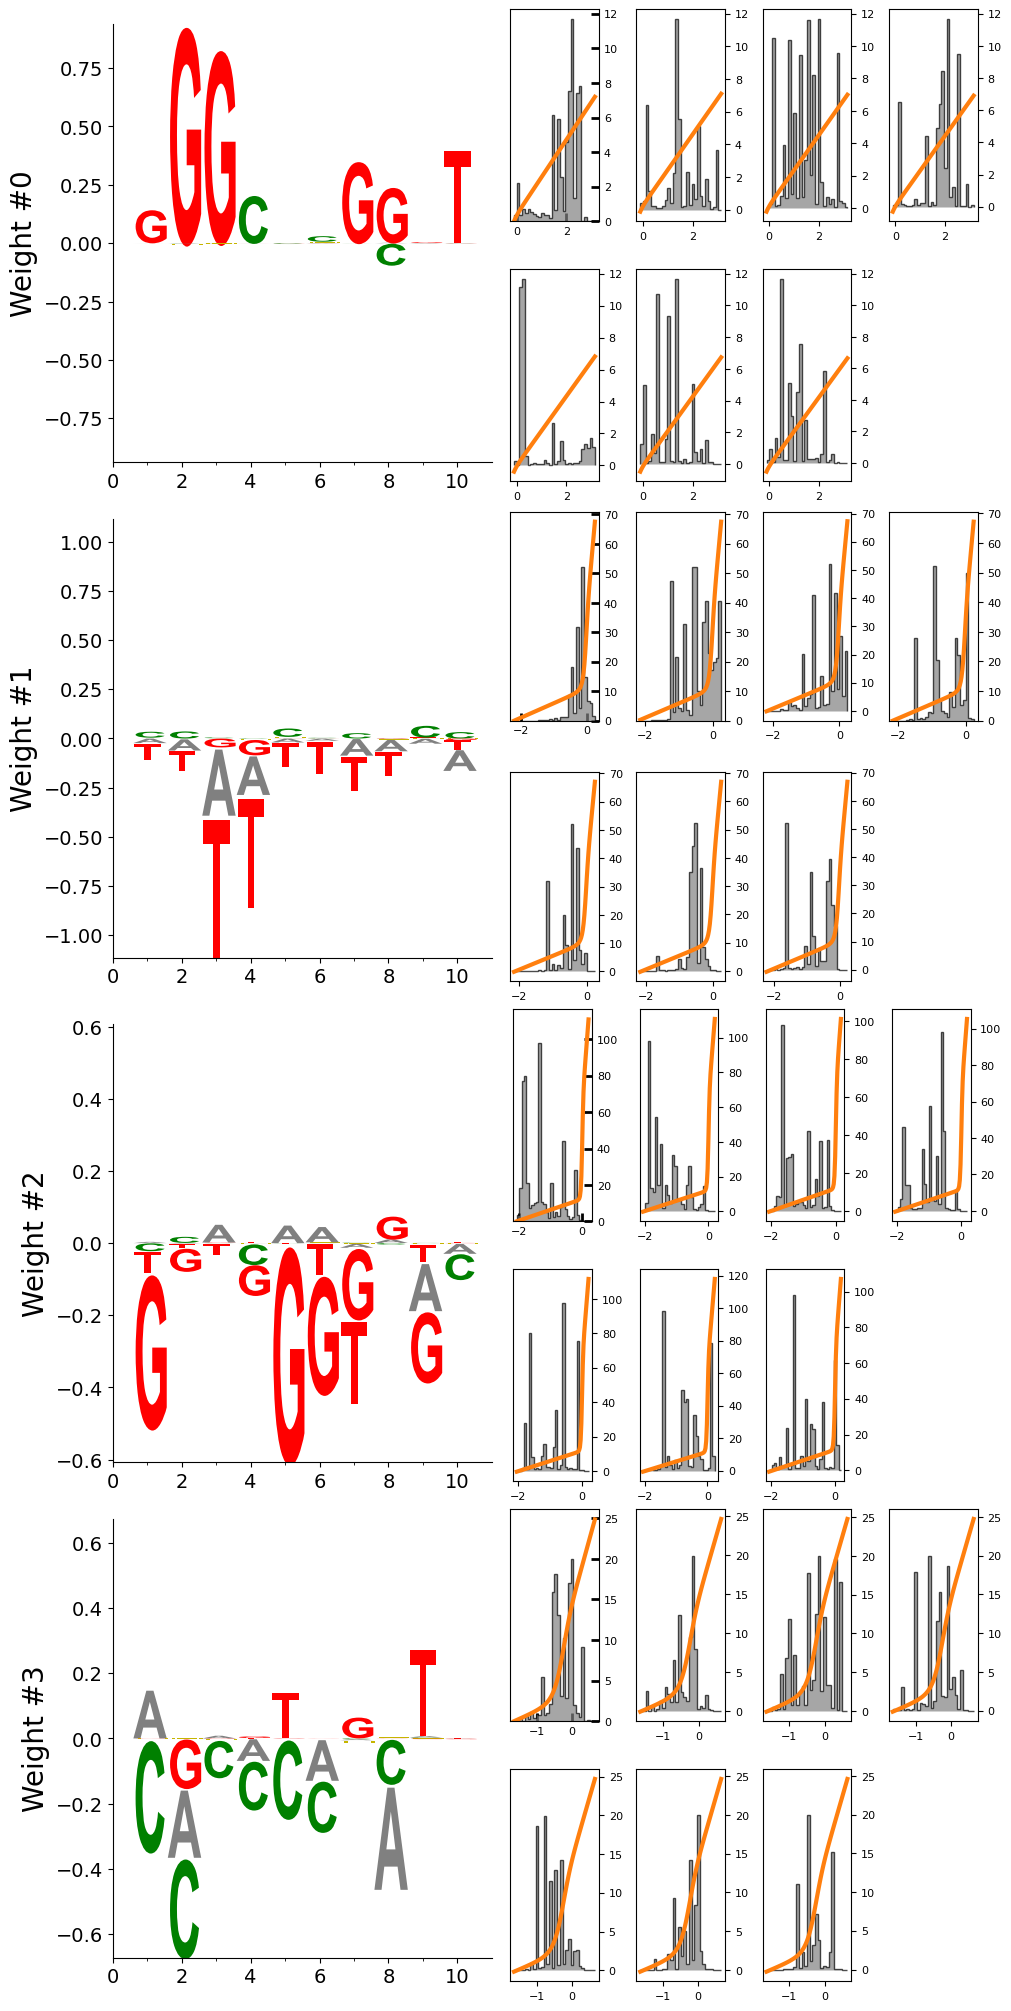

In [9]:
data_with_weights_plot(r12_crbm, all_data[all_data["round"] == "r12"], "hidden1", [0, 1, 2, 3], kdim="full", data="mean")

../rbm_utils.py:442: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../rbm_utils.py:442: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../rbm_utils.py:442: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../rbm_utils.py:442: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)


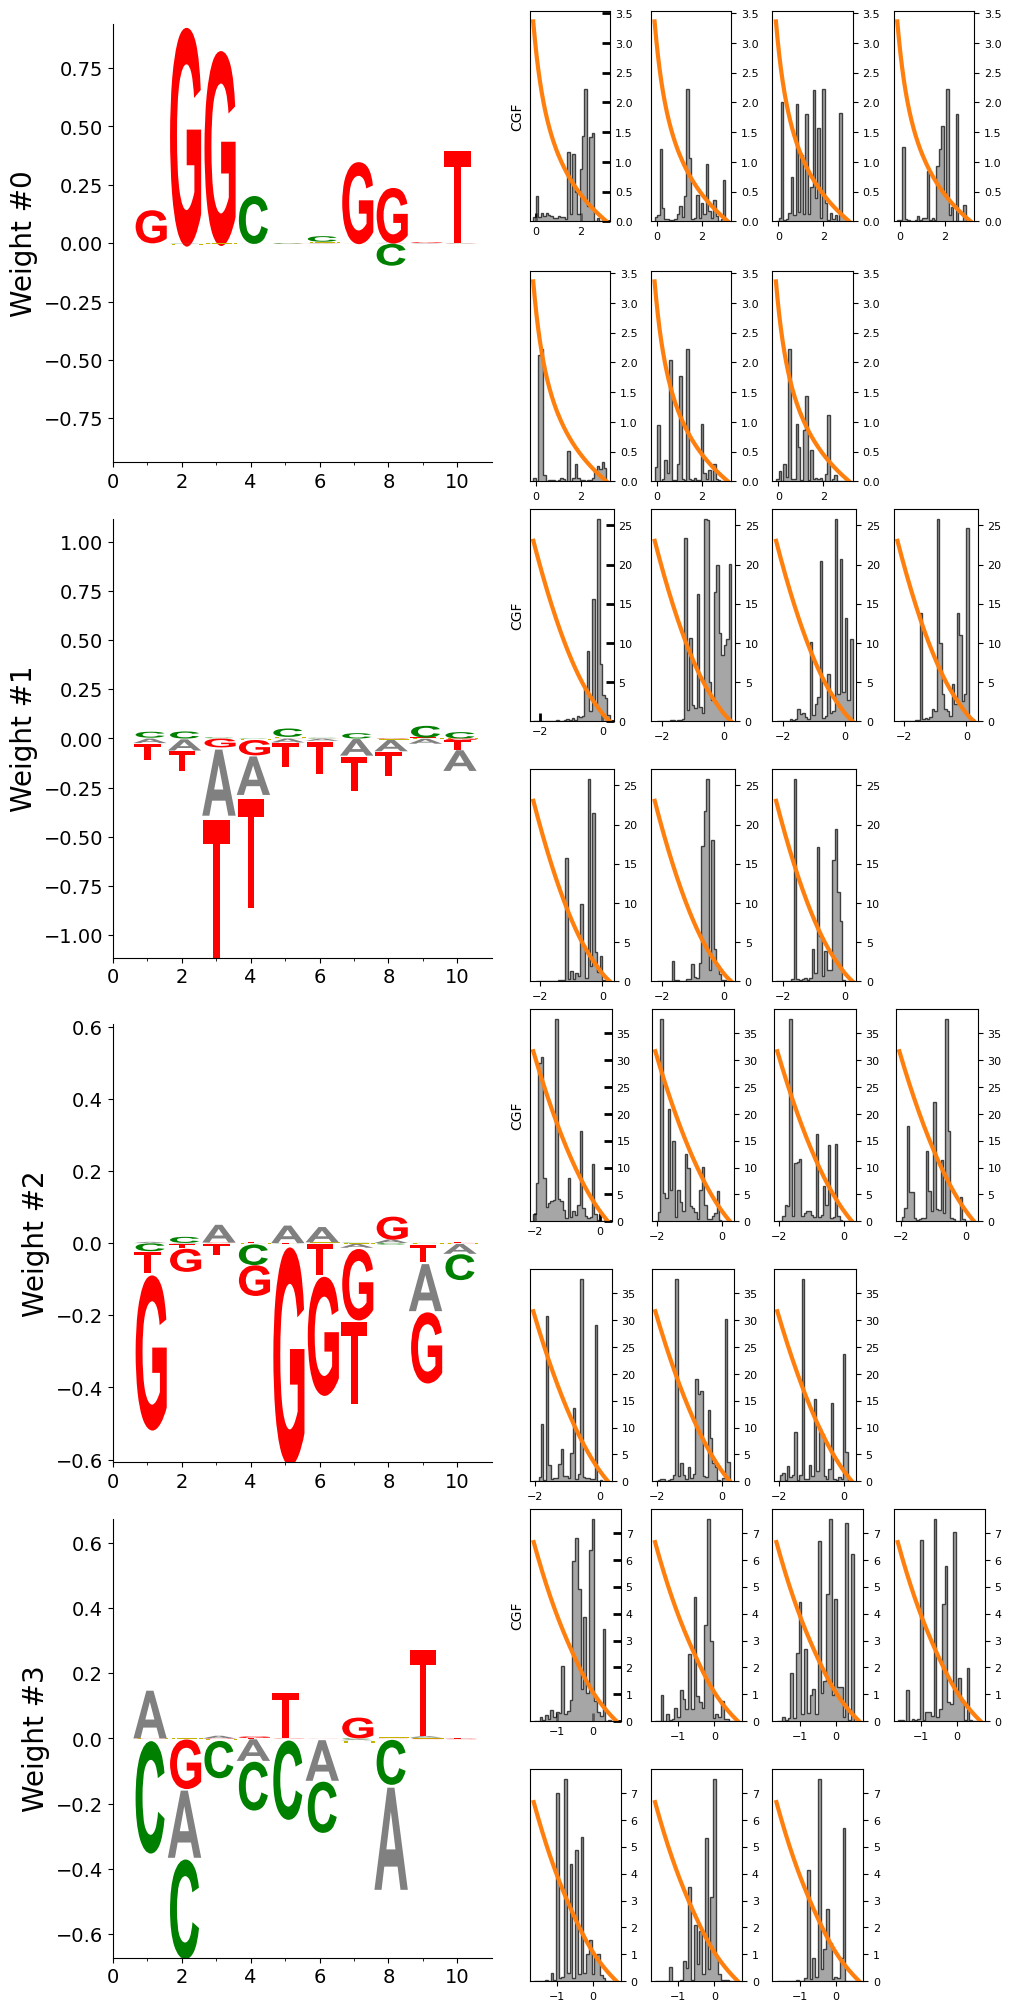

In [8]:
data_with_weights_plot(r12_crbm, all_data[all_data["round"] == "r12"], "hidden1", [0, 1, 2, 3], kdim="full", data="cgf")

../rbm_utils.py:442: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../rbm_utils.py:442: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../rbm_utils.py:442: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../rbm_utils.py:442: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)


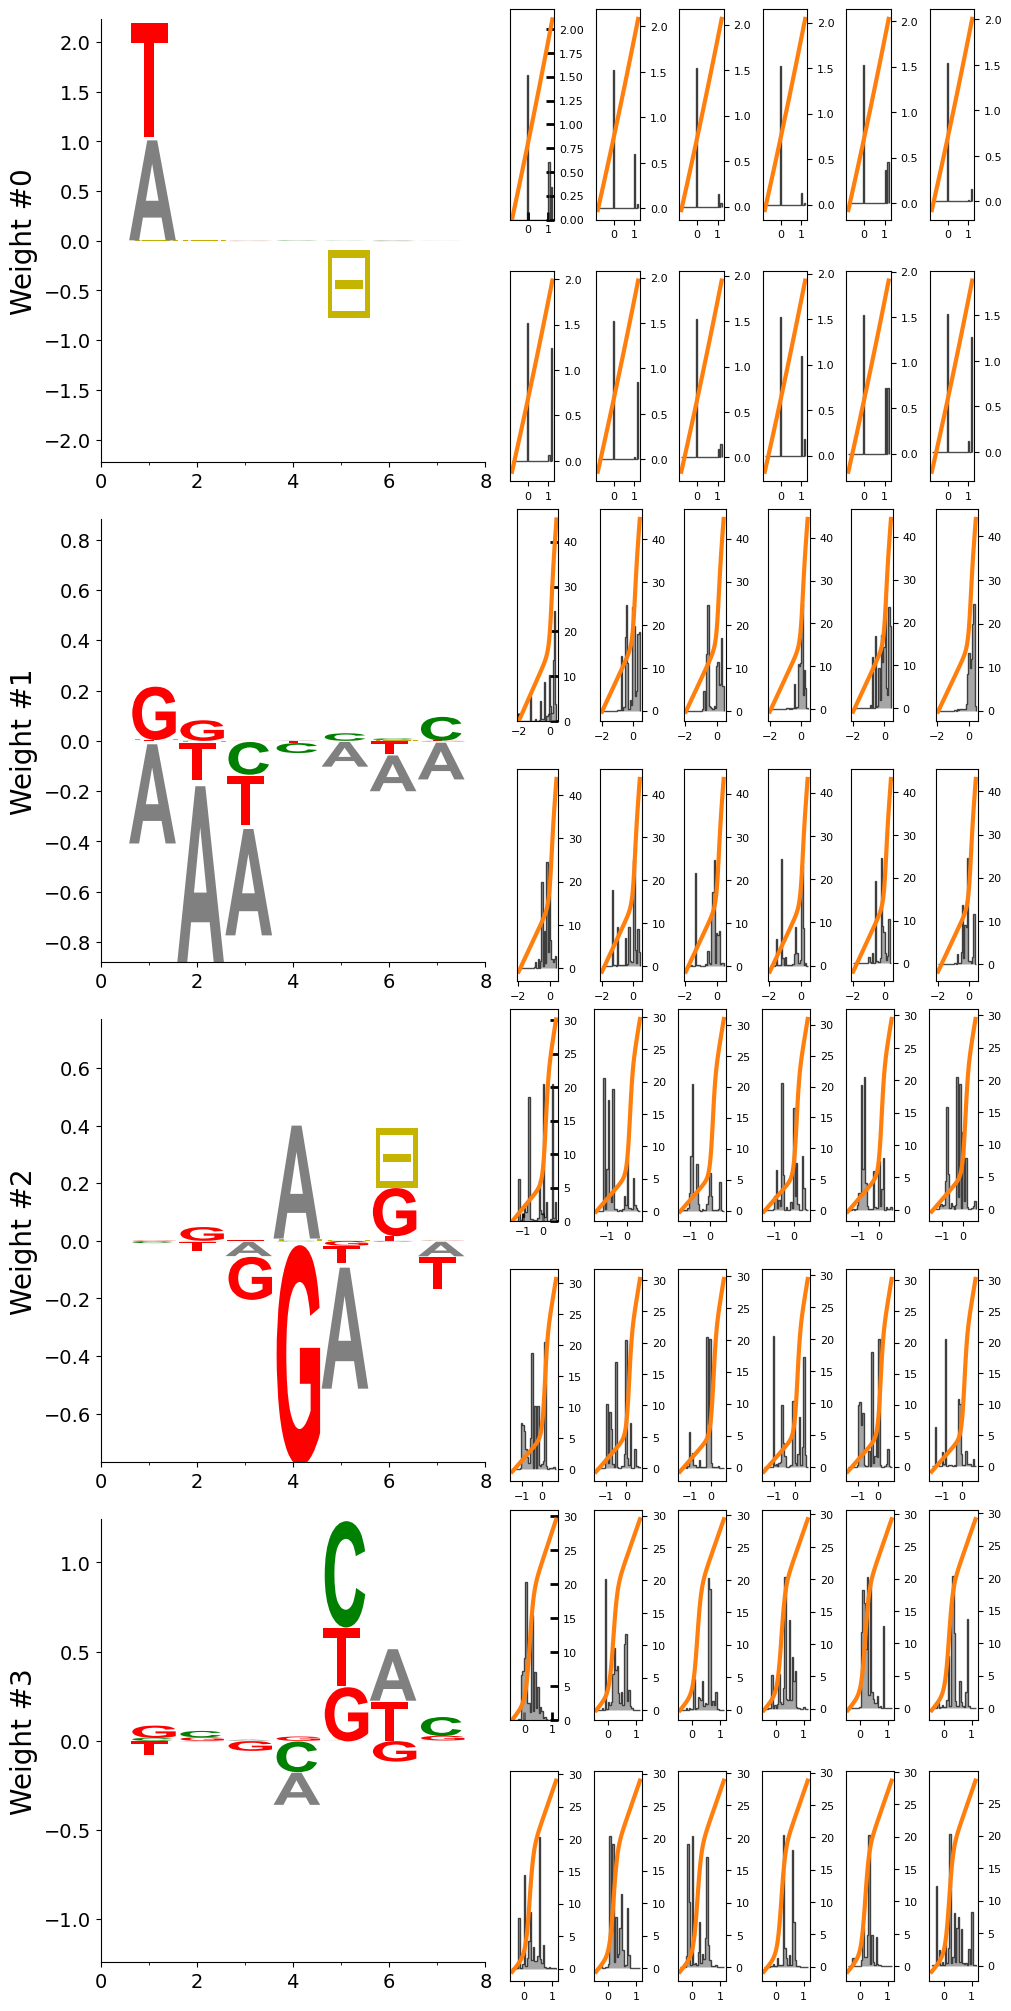

In [10]:
data_with_weights_plot(r12_crbm, all_data[all_data["round"] == "r12"], "hidden2", [0, 1, 2, 3], kdim="full", data="mean")

In [8]:
r12_data = all_data[all_data["round"] == "r12"]
# print(r12_data)

In [24]:
r12_copynum = r12_data.copynum.tolist()

In [9]:
r12_by_copynum = r12_data.sort_values("copynum", ascending=False)

In [12]:
print(r12_by_copynum.head(1000))

                                        sequence   copynum round assignment
231318  GGGAGGGAGGGTGGGGGGTTCTCGCTGCGGGTTTTGGTGC  780426.0   r12          H
175772  AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGATT  650339.0   r12          H
262991  GGGCGGGAGGGAGGGGGGCCACACCAAAACACGTTCAACT  555261.0   r12          H
345325  TCGCGGGGGGCGGGTCGGGTGCTCGTTCGAGGGGTCGCAG  486834.0   r12          H
137124  AAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGAT  445204.0   r12          H
...                                          ...       ...   ...        ...
249664  GGGAGGGAGGGTGGGGGGTTCGCTGCGGGTTTTGGTGCTG     376.0   r12          H
315157  GGGCGGGAGGGAGGGGGGCCCCACCAAAACACGTTCAACT     375.0   r12          H
428121  AGGCTTATCGCCCGGGGGGTGGGCCCGGGTTCGGGGTCGT     374.0   r12          H
97312   AGGAGGGTAGGTAGTGATTGGTAGGGAAACTCCGCCGATT     374.0   r12          H
572362  AAGGAGGGTAGGTAGCGCTTGGTAGGGAAACTCCGCCGAT     374.0   r12          H

[1000 rows x 4 columns]


Clustering by Inputs on hidden nodes

In [17]:
r12_rbm.prep_W() # Very Necessary
r12_cat = am.dataframe_to_input(r12_data, am.int_to_letter_dicts[r12_rbm.molecule], r12_rbm.v_num, weights=False) # Convert sequences to input tensor
r12_h_input = r12_rbm.compute_output_v(r12_cat)

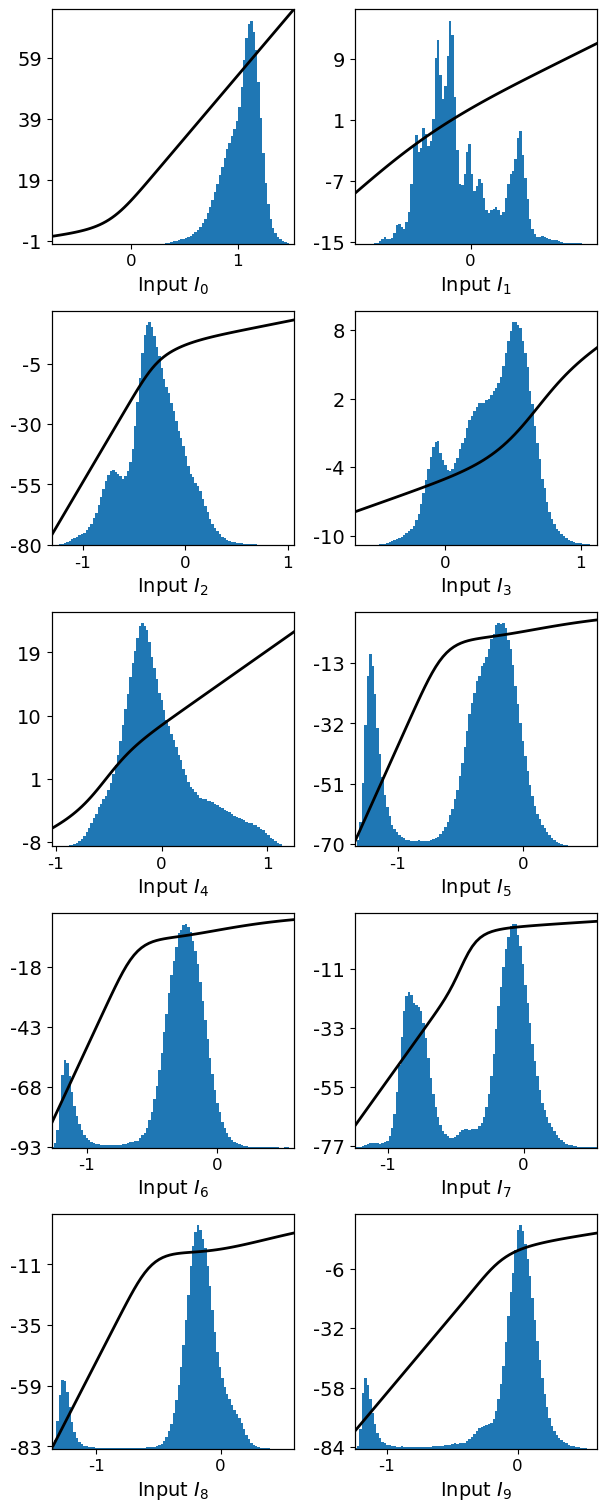

In [20]:
plot_input_mean(r12_rbm, r12_h_input, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [15]:
def cluster_inputs(I, hidden_unit_2d_combo, padding=0.05, size_to=None, hue_to=None, size_label=None, hue_label=None):

    # mean = RBM.mean_h(torch.repeat_interleave(I_range.unsqueeze(1), RBM.h_num, dim=1))

    [hidden1, hidden2] = hidden_unit_2d_combo

    # mean = mean.detach().numpy()
    # I_range = I_range.detach().numpy()
    I = I.detach().numpy()

    xlab = r'Input $I_{%s}$'%hidden1
    ylab = r'Input $I_{%s}$'%hidden2

    Ih1 = I[:, hidden1]
    Ih2 = I[:, hidden2]

    sns.color_palette("mako", as_cmap=True)
    marker_size = 10
    if size_to is not None and hue_to is None:
        dataset = pd.DataFrame({"input1": Ih1, "input2": Ih2, size_label: size_to})
        g = sns.scatterplot(data=dataset, x="input1", y="input2", size=size_label, alpha=0.7, s=marker_size, palette="mako")
    elif size_to is None and hue_to is not None:
        dataset = pd.DataFrame({"input1": Ih1, "input2": Ih2, hue_label: hue_to})
        g = sns.scatterplot(data=dataset, x="input1", y="input2", hue=hue_label, alpha=0.7, s=marker_size, palette="mako")
    elif size_to is not None and hue_to is not None:
        dataset = pd.DataFrame({"input1": Ih1, "input2": Ih2, size_label: size_to, hue_label: hue_to})
        g = sns.scatterplot(data=dataset, x="input1", y="input2", size=size_label, hue=hue_label, alpha=0.7, s=marker_size, palette="mako")
    else:
        dataset = pd.DataFrame({"input1": Ih1, "input2": Ih2})
        g = sns.scatterplot(data=dataset, x="input1", y="input2", alpha=0.7, s=marker_size, palette="mako")

    # sns.histplot(data_w_counts, ax=axs[1], x="round", hue="assignment", multiple="stack", palette="rocket", stat="count")
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    g.set_xlim([Ih1.min()-padding, Ih1.max()+padding])
    g.set_ylim([Ih2.min()-padding, Ih2.max()+padding])
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)

    # How to make Legend if needed
    # leg = g.axes.flat[0].get_legend()
    # new_title = 'Inputs'
    # leg.set_title(new_title)
    # new_labels = ['label 1', 'label 2']
    # for t, l in zip(leg.texts, new_labels):
    #     t.set_text(l)

    plt.show()

In [47]:
I = r12_h_input.detach().numpy()
in1 = I[:, 0]
in2 = I[:, 6]
dataset = pd.DataFrame({"input1": in1, "input2": in2})
g = sns.scatterplot(data=dataset, x="input1", y="input2")

No handles with labels found to put in legend.


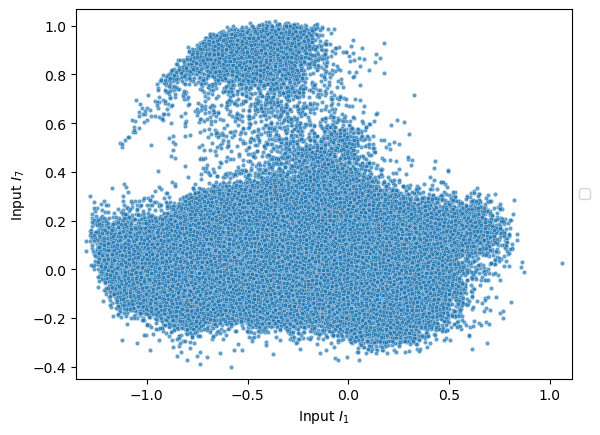

In [21]:
cluster_inputs(r12_h_input, [1, 7], padding=0.05)

In [22]:
r12_likelihoods["likelihoods"]

{'r2': [-121.5203345327262,
  -116.86237052824805,
  -119.48824521214152,
  -110.9294844092276,
  -112.63810464170459,
  -117.15117645979763,
  -122.79637864615503,
  -117.09179931325909,
  -115.75612530982005,
  -120.26661362292495,
  -118.96581719338923,
  -121.49113631363034,
  -117.1023312698214,
  -113.12834335090668,
  -112.71486732140508,
  -118.06131650754492,
  -120.47428532706209,
  -115.6371665971241,
  -114.79344614186078,
  -120.60900088450447,
  -117.83744535831255,
  -116.09586306633781,
  -120.21204984909696,
  -110.62722745355464,
  -110.4771893768251,
  -117.04063019947864,
  -121.3875048562322,
  -115.44836867944667,
  -120.40102877659012,
  -119.11282911402193,
  -115.31501537082778,
  -121.26420545506681,
  -117.72174926330106,
  -119.57272475070525,
  -118.14537313300565,
  -110.21928180684975,
  -117.8027165669435,
  -112.28726585112653,
  -116.87005137684417,
  -110.29408543043044,
  -111.61251385361228,
  -115.48197946049882,
  -121.54818976158725,
  -100.33805

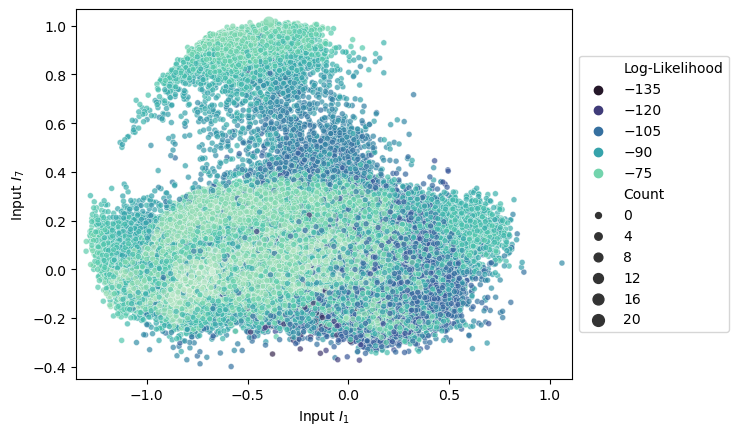

In [26]:
r12_max_cn = [min(int(x/500), 20) for x in r12_copynum]
cluster_inputs(r12_h_input, [1, 7], padding=0.05, size_to=r12_max_cn, size_label="Count", hue_to=r12_likelihoods["likelihoods"]["r12"], hue_label="Log-Likelihood")

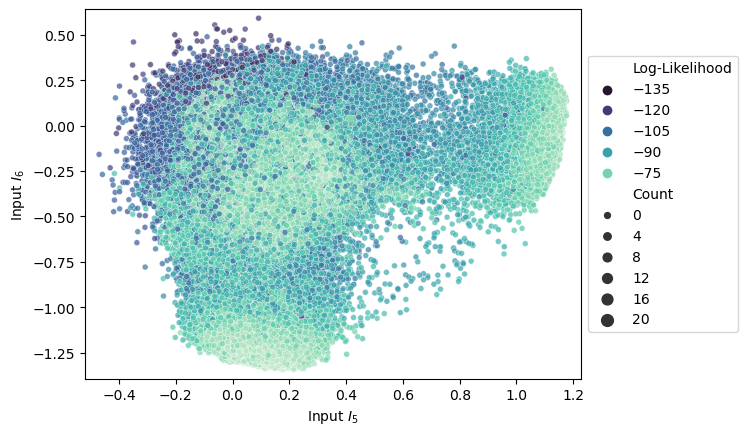

In [27]:
cluster_inputs(r12_h_input, [5, 6], padding=0.05, size_to=r12_max_cn, size_label="Count", hue_to=r12_likelihoods["likelihoods"]["r12"], hue_label="Log-Likelihood")

In [28]:
r12_sub = am.data_subset(all_data, r12_likelihoods["likelihoods"], "r12", -85, 0)

r12_sub_seq = r12_sub.sequence.tolist()
r12_sub_copynum = r12_sub.copynum.tolist()
r12_sub_likelis = r12_sub.likelihood.tolist()

r12_sub_cat = am.dataframe_to_input(r12_sub, am.int_to_letter_dicts[r12_rbm.molecule], r12_rbm.v_num, weights=False)

In [29]:
r12_rbm.prep_W()
r12_sub_input = r12_rbm.compute_output_v(r12_sub_cat)

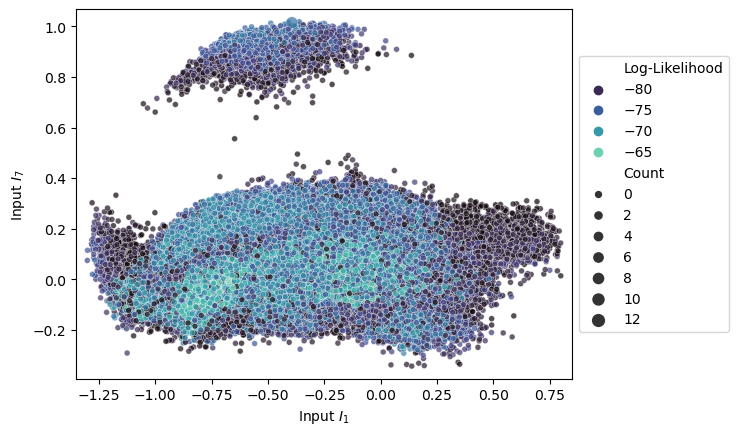

In [32]:
r12_sub_max_cn = [min(int(x / 500), 12) for x in r12_sub_copynum]
cluster_inputs(r12_sub_input, [1, 7], padding=0.05, size_to=r12_sub_max_cn, size_label="Count", hue_to=r12_sub_likelis, hue_label="Log-Likelihood")

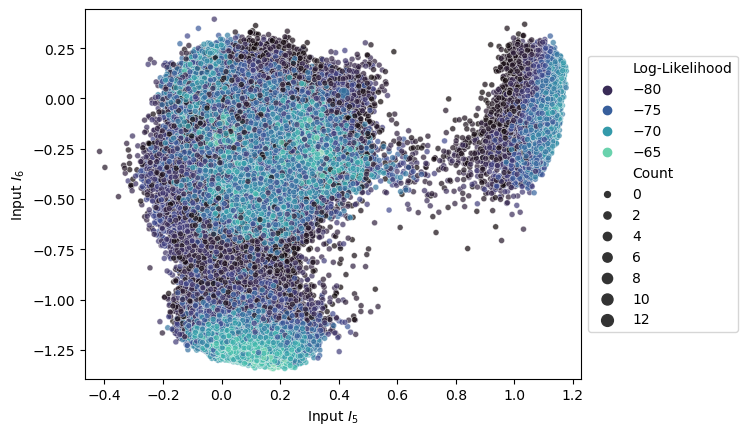

In [33]:
cluster_inputs(r12_sub_input, [5, 6], padding=0.05, size_to=r12_sub_max_cn, size_label="Count", hue_to=r12_sub_likelis, hue_label="Log-Likelihood")

In [ ]:
cluster_inputs(r12_h_input, [0, 1], padding=0.05, size_to=r12_max_cn, size_label="Count", hue_to=r12_likelihoods["likelihoods"]["r12"], hue_label="Log-Likelihood")

In [123]:
r12_h_input.shape

torch.Size([650941, 30])

In [34]:
# Primary Component Analysis
from sklearn.decomposition import PCA
X = r12_h_input.detach().numpy()

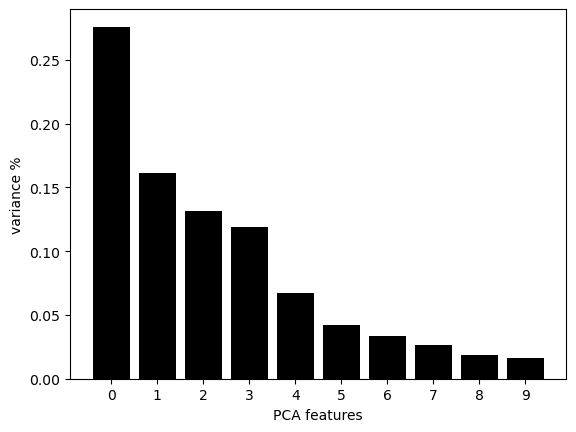

In [141]:
# First PCA pass to decide number of components
# pca = PCA(n_components=10)
# principal_components = pca.fit_transform(X)
# PCA_components = pd.DataFrame(principal_components)

features = range(1, pca.n_components_+1)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

In [35]:
# We will do the first 4 components only, Drop in variance at feature 5
pca_4 = PCA(n_components=4)
principal_components_4 = pca_4.fit_transform(X)
PCA_components_4 = pd.DataFrame(principal_components_4)

In [40]:
components = pca_4.components_
print(components[0])

[-2.24884550e-01 -1.05888655e-01  1.22539384e-01 -8.51673994e-02
 -1.30015822e-01  1.06026170e-01  5.46191477e-01  1.60419422e-02
  5.23319500e-02  3.10777603e-02  2.31097633e-02  4.04249077e-02
 -3.84708220e-02  6.49017748e-02 -2.58332870e-01  1.13417187e-01
  1.63277858e-01 -4.42655829e-07  4.99829217e-01 -2.31390584e-02
  1.50650435e-01  1.19137041e-01 -3.12663776e-01  2.09275567e-01
 -3.81060488e-02  5.31099416e-02 -4.70908997e-02 -9.23949143e-03
 -8.71429037e-02  1.68566864e-01]


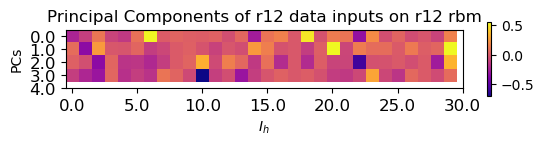

In [58]:
fig, axs = plt.subplots(1, 1)
pos = axs.imshow(components, cmap='plasma', interpolation='none')
axs.set_title("Principal Components of r12 data inputs on r12 rbm")
axs.set_xlabel(r"$I_{h}$")
axs.set_ylabel("PCs")
xticks = np.arange(int(0.5), int(30) + 0.5, 5)
yticks = np.arange(int(0.5), int(4) + 0.5, 1)
axs.set_xticks(xticks)
axs.set_yticks(yticks)
axs.set_xticklabels(xticks, fontsize=12)
axs.set_yticklabels(yticks, fontsize=12)
fig.colorbar(pos, ax=axs, anchor=(0, 0.3), shrink=0.2)
plt.show()

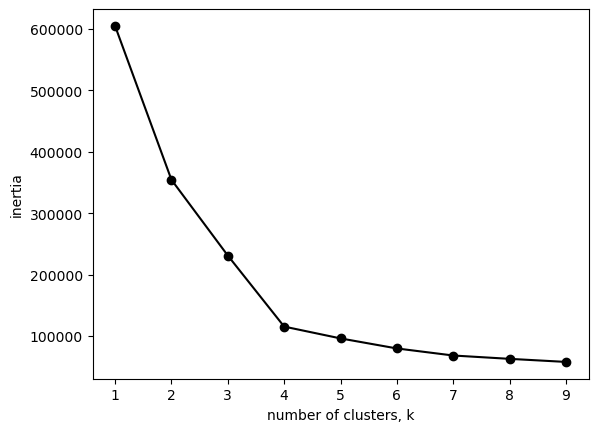

In [59]:
# KMeans on Transformed Sequences

from sklearn.cluster import KMeans
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(PCA_components_4.iloc[:,:3])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [62]:
# Elbow Point is at 4 so we will run it for 4 clusters
kmeans_pca = KMeans(n_clusters=4, init="k-means++", random_state=38)
kmeans_pca.fit(principal_components_4)
# Add principal components to dataframe
df_pca_kmeans = pd.concat([r12_data.reset_index(drop=True), pd.DataFrame(principal_components_4)], axis=1)
df_pca_kmeans.columns.values[-4:] = ["Component 1", "Component 2", "Component 3", "Component 4"]
# Add labels from kmeans
df_pca_kmeans["K-mean PCA Label"] = kmeans_pca.labels_
# Replace integer with label in new column
df_pca_kmeans["Segment"] = df_pca_kmeans["K-mean PCA Label"].map({0:'first', 1:'second', 2:"third", 3:'fourth'})

/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


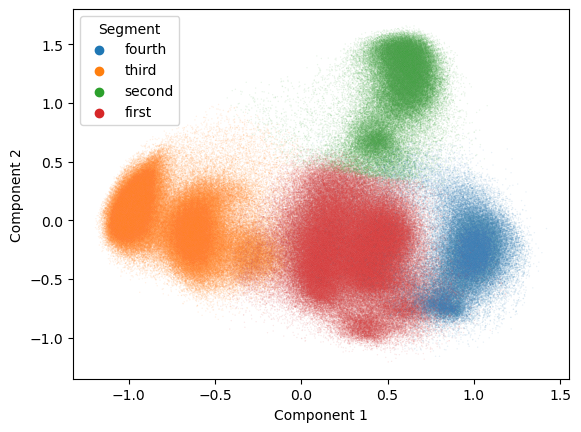

In [80]:
sns.scatterplot(data=df_pca_kmeans, x="Component 1", y="Component 2", hue="Segment", alpha=0.1, s=1)
plt.show()

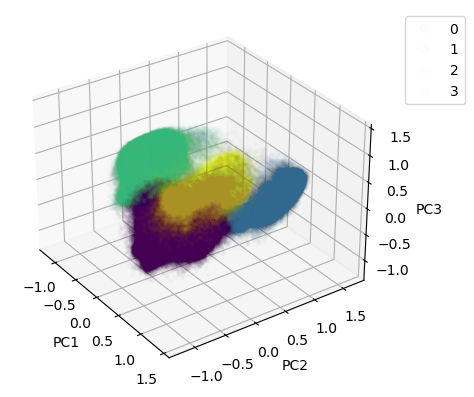

In [67]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, -35)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

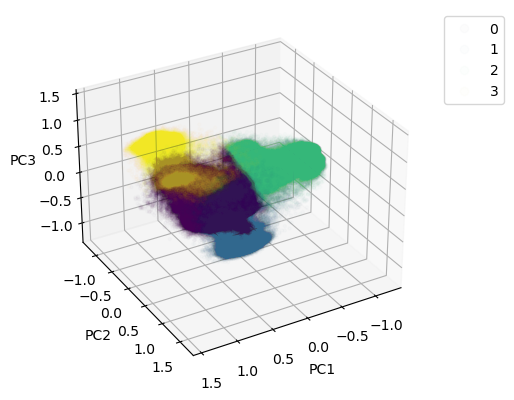

In [78]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, 60)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

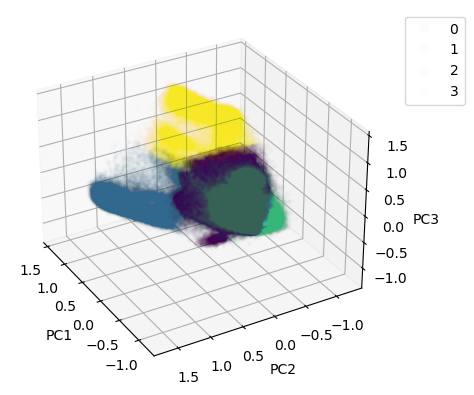

In [77]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, 150)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

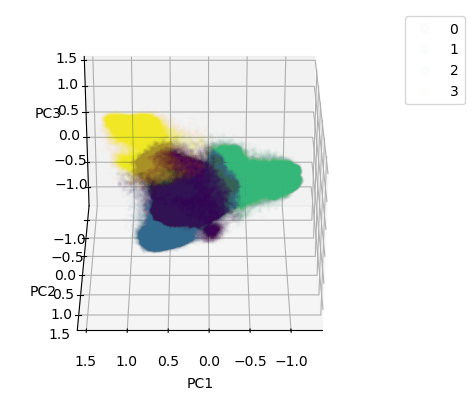

In [76]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, 90)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

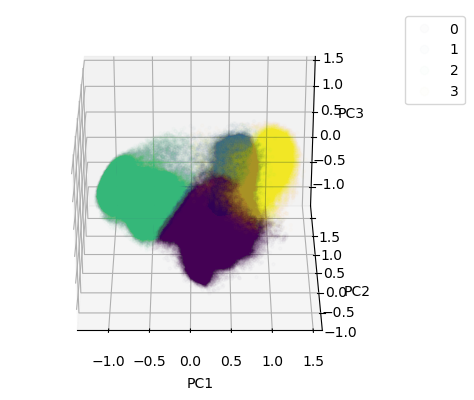

In [75]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, 270)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

Now we need to see what the primary components are learning

In [83]:
# Basic Idea
# Add weights of inputs with additional weighting of the weights (lol) by the primary components

r12_beta, r12_W = get_beta_and_W(r12_rbm)


In [91]:
prod_1 = r12_W*components[0][:, None, None]
avg_W = prod_1.mean(axis=0)

In [108]:
def pca_avg_weights(W, components, molecule="dna"):
    pcs = components.shape[0]
    v_num = W.shape[1]
    fig, axs = plt.subplots(pcs, 1, figsize=(int(v_num/5), 3*pcs))
    fig.suptitle("PCA Average Weights")
    products = np.zeros((pcs, *W.shape[1:]), dtype=np.float)
    for i in range(pcs):
        prod = W*components[i][:, None, None]
        products[i] = prod.mean(axis=0)
        ax = axs[i]
        rbm_utils.Sequence_logo(products[i], ax=ax, data_type="weights", ylabel=f"PC{i+1}", show=False, molecule=molecule, ticks_every=10)
    plt.show()
    return products



In [122]:
def get_sequences_from_W(W_matrix, base_to_id, gaps=True):
    max_seqs, min_seqs = [], []
    inv_base_to_id = {v: k for k, v in base_to_id.items()}
    if not gaps:
        W_matrix = W_matrix[:, :, :-1]
    for i in range(W_matrix.shape[0]):
        max_seq_int = list(np.argmax(W_matrix[i], axis=1))
        min_seq_int = list(np.argmin(W_matrix[i], axis=1))
        max_seq = "".join([inv_base_to_id[x] for x in max_seq_int])
        min_seq = "".join([inv_base_to_id[x] for x in min_seq_int])
        max_seqs.append(max_seq)
        min_seqs.append(min_seq)
    return max_seqs, min_seqs

../rbm_utils.py:439: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)


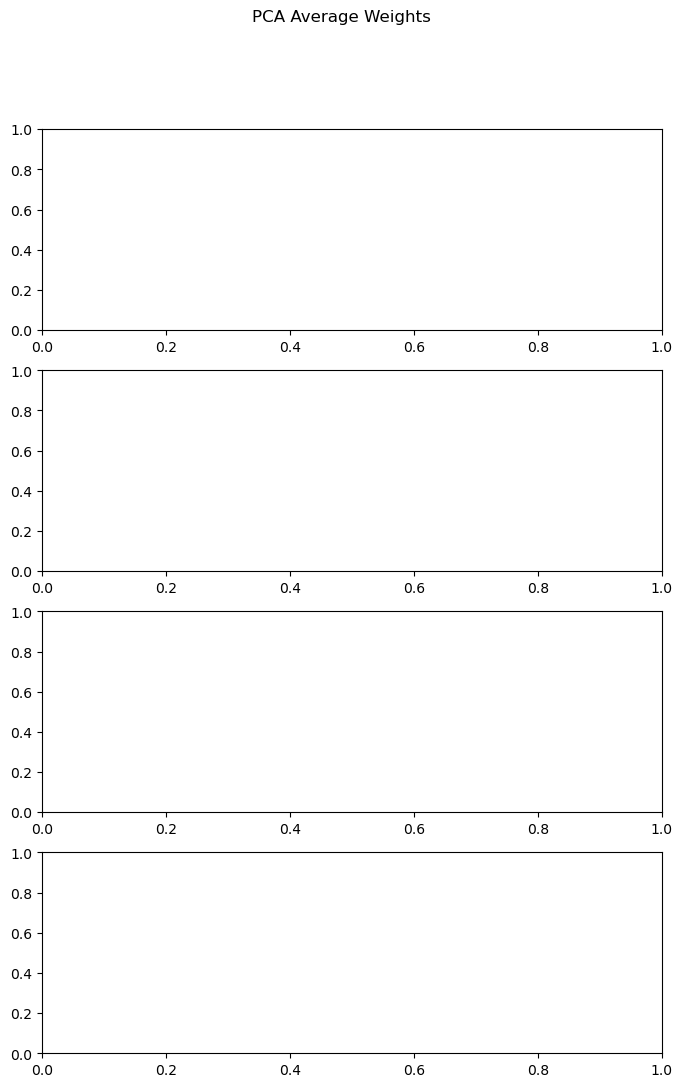

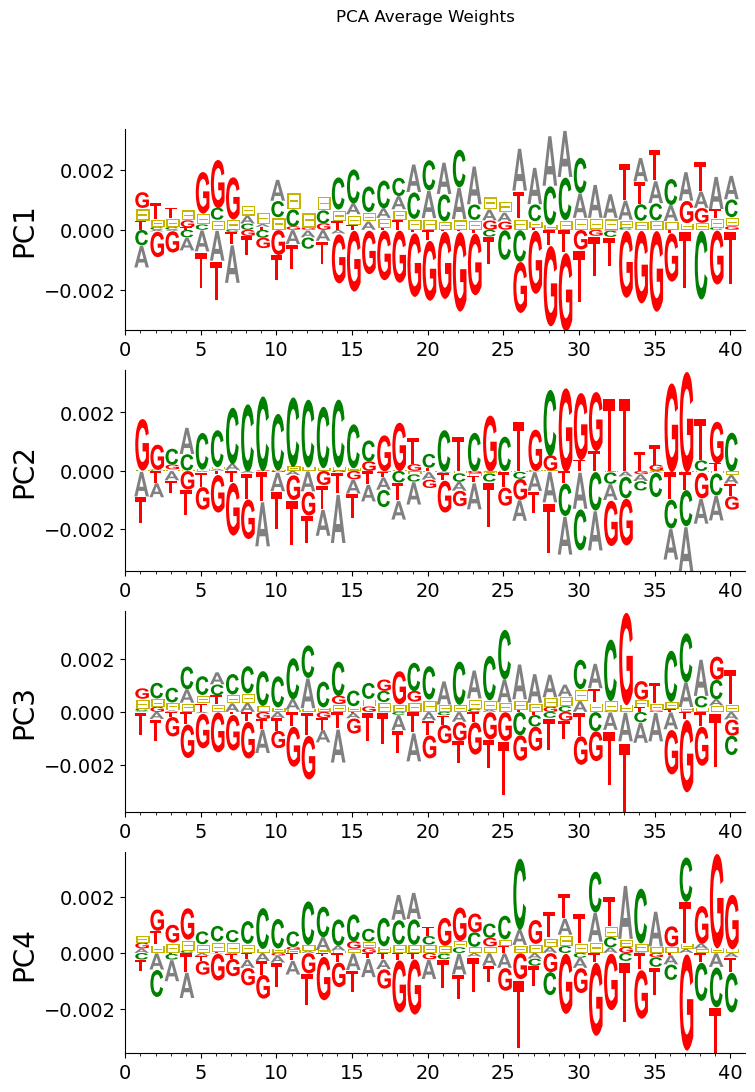

In [109]:
avg_W = pca_avg_weights(r12_W, components, molecule="dna")

In [119]:
max_seqs, min_seqs = get_sequences_from_W(avg_W, rbm_utils.dnadictU, gaps=True)

In [120]:
max_seqs

['GTT-GGG--A---CCCCCACACA--AAAACAATATCATAA',
 'GGCACCCCCCCCCCCCGGTCCTCGCTGCGGGTTTTGGTGC',
 'GCCCCACCCCCCCCCCGGCCACACCAAAACACGGTCCAGT',
 '-GGGCCCCCCCCCCCCCAATGGGCCCGTTTCTACAGCGGG']

In [121]:
min_seqs

['AGGATTATGTTCTGGGGGGGGGGTCGGGGTTTGGGGTCGT',
 'TATTGGGGATTTAATACAAGGGATGATTACAGGCCAAAAG',
 'TTGGGGGGAGGGAAGTTTAGGTGTTGGTTGGTTAAGGGTC',
 'TCAAGGGGGTATGGTAGGGATTTTGTTCGGGGTGTCGCTC']

In [125]:
max_seqs_no_g, min_seqs_no_g = get_sequences_from_W(avg_W, rbm_utils.dnadictU, gaps=False)

In [126]:
max_seqs_no_g

['AGGATTATGTTCTGGGGGGGGGGTCGGGGTTTGGGGTCGT',
 'TATTGGGGATTTAATACAAGGGATGATTACAGGCCAAAAG',
 'TTGGGGGGAGGGAAGTTTAGGTGTTGGTTGGTTAAGGGTC',
 'TCAAGGGGGTATGGTAGGGATTTTGTTCGGGGTGTCGCTC']

Let's try the same exact thing on round 2 now

In [6]:
# Produces flat vector of Inputs of each hidden unit (reduced over the convolution dimension (k) by sum or mean)
def flatten_and_reduce_input(Ih, reduction="sum"):
     # Iuk (Batch, hidden number (u), conv number (k))
    if reduction == "sum":
        return torch.cat([Iuk.sum(2) for Iuk in Ih], 1)
    elif reduction == "mean":
        return torch.cat([Iuk.mean(2) for Iuk in Ih], 1)
    else:
        print(f"Reduction {reduction} not supported", file=sys.stderr)
        exit(-1)

def prepare_input_vector(crbm, dataframe):
    base_to_id = am.int_to_letter_dicts[crbm.molecule]
    data_tensor, weights = dataframe_to_input_crbm(dataframe, base_to_id, crbm.v_num, crbm.q, weights=True)
    input_hiddens = crbm.compute_output_v(data_tensor) # List of Iuk matrices
    return flatten_and_reduce_input(input_hiddens).detach().numpy()

In [12]:
from sklearn.preprocessing import StandardScaler
input = prepare_input_vector(r12_crbm, r12_data)
scaler = StandardScaler()
input_processed = scaler.fit_transform(input)

In [46]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

cluster_method = "db"
if cluster_method == "db":
    alg = DBSCAN(eps=1.8, metric='euclidean', min_samples=5000).fit(input_processed)
    core_samples_mask = np.zeros_like(alg.labels_, dtype=bool)
    core_samples_mask[alg.core_sample_indices_] = True

elif cluster_method == "op":
    alg = OPTICS(min_samples=2000, metric="euclidean").fit(input_processed)
    # core_distance_mask = np.zeros_like(alg.labels_, dtype=bool)
    # core_samples_mask[alg.core_sample_indices_] = True


labels = alg.labels_

In [48]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
cluster_id = set(labels)
for clust in cluster_id:
    print('Clust', clust, 'Length', list(labels).count(clust))

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Clust 0 Length 64206
Clust 1 Length 29728
Clust 2 Length 217801
Clust 3 Length 72241
Clust 4 Length 66688
Clust 5 Length 25061
Clust 6 Length 4459
Clust 7 Length 11366
Clust 8 Length 8262
Clust 9 Length 8348
Clust 10 Length 9604
Clust 11 Length 2128
Clust 12 Length 2212
Clust 13 Length 1143
Clust -1 Length 127694
Estimated number of clusters: 14
Estimated number of noise points: 127694


In [ ]:
# Now we should try to visualize each clusters sequence logo

r12_db_data = r12_data
r12_db_data["cluster"] = list(labels)

# Generate Sequence Logo for Each Cluster
db_paths_u, db_paths_w = [], []
for clust in cluster_id:
    db_paths_u.append(am.seq_logo(r12_db_data[r12_db_data["cluster"] == clust], f"db_c{clust}_seqlogo", weight=False, outdir="./generated/"))
    db_paths_w.append(am.seq_logo(r12_db_data[r12_db_data["cluster"] == clust], f"db_c{clust}_seqlogo", weight=True, outdir="./generated/"))


# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds):
    img1 = mpimg.imread(f"{db_paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{db_paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()



In [11]:
# Primary Component Analysis
from sklearn.decomposition import PCA

# r12_data = all_data[all_data["round"] == "r12"]
# input = prepare_input_vector(r12_crbm, r12_data)
# scaler = StandardScaler()
# X = scaler.fit_transform(input)

X = input_processed
# First PCA pass to decide number of components
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X)
PCA_components = pd.DataFrame(principal_components)

features = range(1, pca.n_components_+1)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

NameError: name 'StandardScaler' is not defined

In [13]:
# We will do the first 4 components only, Drop in variance at feature 5
X = input_processed
pca_4 = PCA(n_components=4)
principal_components_4 = pca_4.fit_transform(X)
PCA_components_4 = pd.DataFrame(principal_components_4)

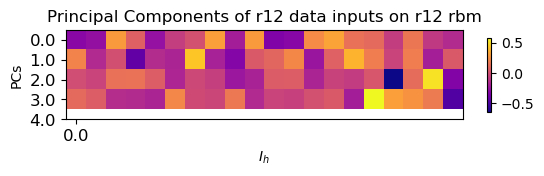

In [34]:
components = pca_4.components_

fig, axs = plt.subplots(1, 1)
pos = axs.imshow(components, cmap='plasma', interpolation='none')
axs.set_title("Principal Components of r12 data inputs on r12 crbm")
axs.set_xlabel(r"$I_{h}$")
axs.set_ylabel("PCs")
xticks = np.arange(int(0.5), int(components.shape[0]) + 0.5, 5)
yticks = np.arange(int(0.5), int(4) + 0.5, 1)
axs.set_xticks(xticks)
axs.set_yticks(yticks)
axs.set_xticklabels(xticks, fontsize=12)
axs.set_yticklabels(yticks, fontsize=12)
fig.colorbar(pos, ax=axs, anchor=(0, 0.3), shrink=0.2)
plt.show()

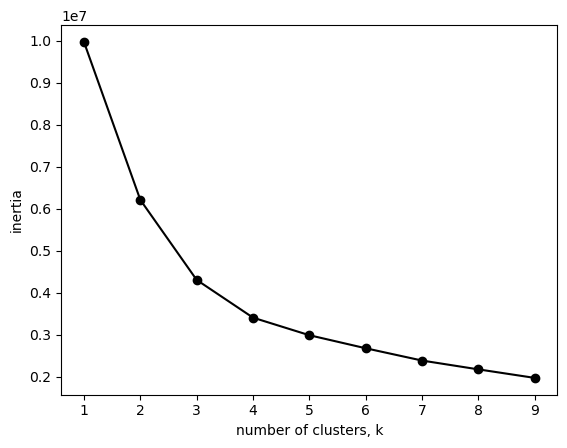

In [20]:
# KMeans on Transformed Sequences

from sklearn.cluster import KMeans
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(PCA_components_4.iloc[:,:4])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [27]:
# Elbow Point is at 4 so we will run it for 4 clusters
kmeans_pca = KMeans(n_clusters=7, init="k-means++", random_state=38)
kmeans_pca.fit(principal_components_4)
# Add principal components to dataframe
df_pca_kmeans = pd.concat([r12_data.reset_index(drop=True), pd.DataFrame(principal_components_4)], axis=1)
df_pca_kmeans.columns.values[-4:] = ["Component 1", "Component 2", "Component 3", "Component 4"]
# Add labels from kmeans
df_pca_kmeans["K-mean PCA Label"] = kmeans_pca.labels_
# Replace integer with label in new column
df_pca_kmeans["Segment"] = df_pca_kmeans["K-mean PCA Label"].map({0:'first', 1:'second', 2:"third", 3:'fourth', 4:'fifth', 5:"sixth", 6:"seventh", 7:"eighth"})

/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


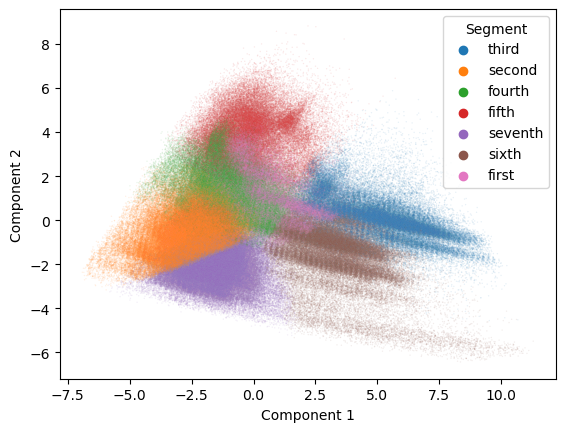

In [28]:
sns.scatterplot(data=df_pca_kmeans, x="Component 1", y="Component 2", hue="Segment", alpha=0.1, s=1)
plt.show()

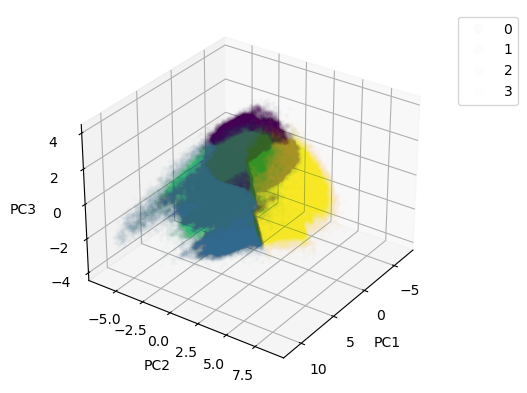

In [39]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, 35)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

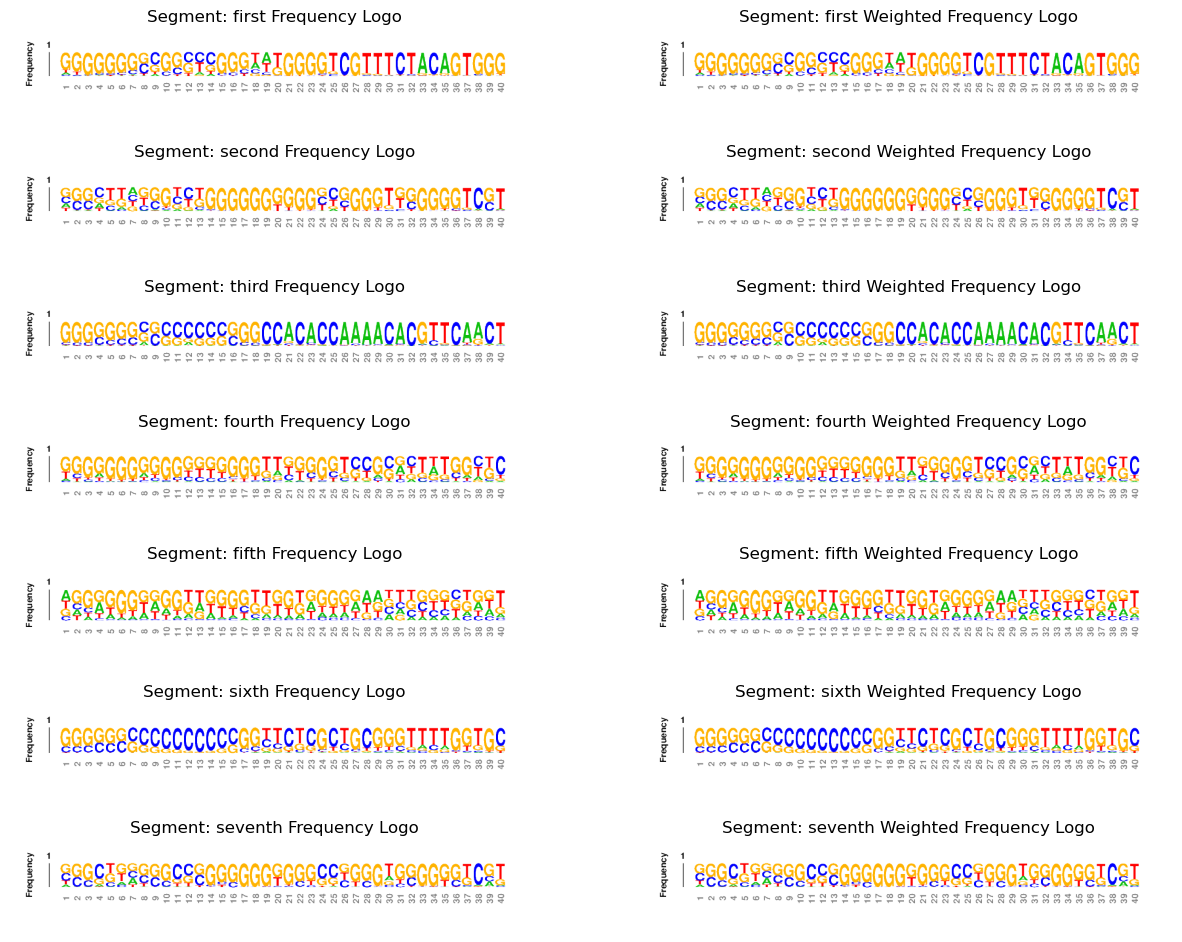

In [30]:
segments = ["first", "second", "third", "fourth", "fifth", "sixth", "seventh"]

# Generate Sequence Logo for Each Cluster
pca_paths_u, pca_paths_w = [], []
for seg in segments:
    pca_paths_u.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"db_c{seg}_seqlogo", weight=False, outdir="./generated/"))
    pca_paths_w.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"db_c{seg}_seqlogo", weight=True, outdir="./generated/"))


# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(segments), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(segments):
    img1 = mpimg.imread(f"{pca_paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{pca_paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"Segment: {r} Frequency Logo")
    axs[rid][1].set_title(f"Segment: {r} Weighted Frequency Logo")

plt.show()

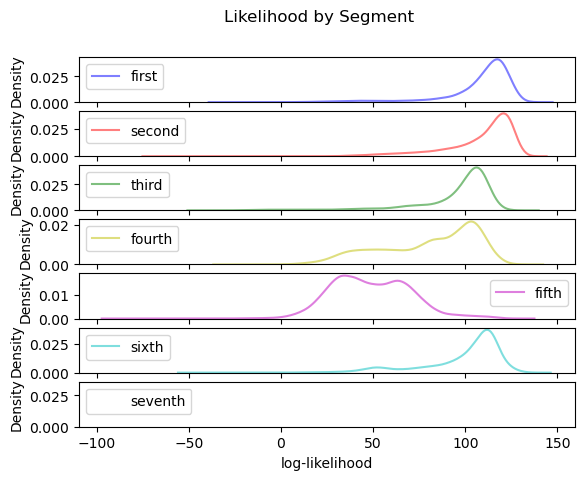

In [39]:
segments = ["first", "second", "third", "fourth", "fifth", "sixth", "seventh"]
# Plot Likelihood Curves of individual segments
df_pca_kmeans["likelihood"] = r12_likelihoods["likelihoods"]["r12"]
likelihood_dict = {}
for seg in segments:
    segment_subset = df_pca_kmeans[df_pca_kmeans["Segment"] == seg]
    likelihoods = segment_subset.likelihood.tolist()
    likelihood_dict[seg] = likelihoods


am.plot_likelihoods(likelihood_dict, segments, segments, title="Likelihood by Segment", xlim=None)

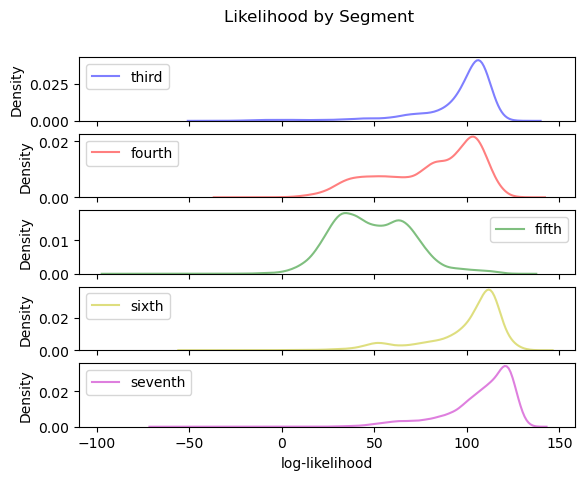

In [40]:
am.plot_likelihoods(likelihood_dict, segments[-5:], segments[-5:], title="Likelihood by Segment", xlim=None)

In [ ]:
am.plot_likelihoods(r12_likelihoods["likelihoods"], segments, segments, title=None, xaxislabel="log-likelihood", xlim=None, cdf=False)